<a id="top_section"></a>
<div align='center'><font size="6" color="#000000"><b>Bank Marketing - Ensemble Learning Pipeline</b></font></div>
<hr>
<div align='center'><font size="4" color="#000000">Ensemble Learning Pipeline Experiments on Imbalanced Binary Classification Problem</font></div>
<hr>

# Table of Contents
* [Introduction](#Introduction)
* [Read and explore data](#Read_and_explore_data)
* [EDA](#eda)
* [Feature Engineering](#Feature_Engineering)
* [Initial Experiment](#Init_exp)
* [Some Basic Classifiers](#basic_classifiers)
* [Voting Classifiers](#voting_classifiers)
* [Bagging Classifiers](#bagging_classifiers)
* [Boosting Classifiers](#boosting_classifiers)
* [Stacking Classifiers](#stacking_classifiers)
* [Extra on Feature Importanceg](#feature_imp)
* [References](#References)

<a id="Introduction"></a>
# Introduction
The context of the Bank Marketing Dataset: The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). Further information about the dataset and features details can be found in [https://archive.ics.uci.edu/ml/datasets/Bank+Marketing](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

* The purposes of this notebook are to experiment on the following topics:
    - Imbalanced Binary Classification.
    - Solving Data Leakage via Cross-Validation
    - Training pipeline
    - Hyperparameter optimization
    - Ensemble Learning Binary Classification Models (Voting, Bagging, Boosting and Stacking Classifiers)
* Full Model Training pipeline:
    - WOE Encoding for categorical features (and Feature Scaling)
    - SMOTE technique for Imbalanced Classification
    - Stratified K-Folds Cross-Validation
    - GridSearchCV with experiments on different single classifiers and ensemble learning classifiers
    - Trained models will be stored as list as it could be reused within the notebook or model export for future uses.
* The output will compare each model with different metrics such as Accuracy, Precision, ROC AUC, F1, Fbeta, and Matthews Correlation Coefficient (MCC).
* Some factors should be considered as the model should minimize the false positive (customers who have not deposited but classify as yes) as the telesales would miss the potential customers. However, the other perspective is that if you keep calling the customers, who already have their deposit, it is aslo costing the bank - depending on the bank's financial cost model.
* In short, the F1 macro score will be the primary comparison metric as it would be suitable for the imbalanced binary classification problem. Other metrics will be considered depending on different preferences.

The notebook was built up in a modular way, which could be expanded for further different experiments such as other Categorical Encoders, Sampling techniques, or various hyperparameter optimizations such as Random search, Bayesian, etc.

In [1]:
# package install
!pip uninstall -q -y autogluon.core
# !pip uninstall -q -y autogluon
# !pip uninstall -q -y mxnet
!pip install --upgrade -q pip
!pip install -q category_encoders==2.2.2
!pip install -q imblearn
!pip install -q scikit-learn==0.23.2
!pip install -q xgboost==1.3.3
!pip install -q lightgbm==2.3.1
!pip install -q catboost==0.24.3
!pip install -q mlxtend
!pip install -q ipython-autotime
%load_ext autotime

time: 691 µs (started: 2021-02-09 05:55:55 +00:00)


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import sys
import warnings
warnings.filterwarnings("ignore")
    
import time
import math
from collections import Counter
import itertools
import scipy.stats as ss

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100) # Setting pandas to display a N number of columns

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.gridspec as gridspec
matplotlib_axes_logger.setLevel('ERROR')

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score, fbeta_score, matthews_corrcoef, make_scorer, roc_curve
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.tree import export_graphviz

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import mlxtend
from mlxtend.classifier import StackingCVClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

import category_encoders
from category_encoders import WOEEncoder

import xgboost
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

import catboost
from catboost import CatBoostClassifier

print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("seaborn version: ", sns.__version__)
print("skearn version:", sklearn.__version__)
print("mlxtend version: ", mlxtend.__version__)
print("imblearn version: ", imblearn.__version__)
print("XGBoost version: ", xgboost.__version__)
print("lightgbm version: ", lgb.__version__)
print("catboost version: ", catboost.__version__)
print("category_encoders version: ", category_encoders.__version__)

/kaggle/input/bank-marketing-data-set/bank-additional.csv
/kaggle/input/bank-marketing-data-set/bank-additional-names.txt
/kaggle/input/bank-marketing-data-set/bank-additional-full.csv


Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
Version info.: sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
pandas version: 1.1.5
numpy version: 1.17.5
seaborn version:  0.10.0
skearn version: 0.23.2
mlxtend version:  0.18.0
imblearn version:  0.7.0
XGBoost version:  1.3.3
lightgbm version:  2.3.1
catboost version:  0.24.3
category_encoders version:  2.2.2
time: 5.15 s (started: 2021-02-09 05:55:55 +00:00)


<a id="Read_and_explore_data"></a>

# Read and explore data
[Back To Table of Contents](#top_section)

In [3]:
link = "../input/bank-marketing-data-set/bank-additional-full.csv"
df_bank = pd.read_csv(link, sep=';')

# Drop duplicated 
df_bank.drop_duplicates(inplace=True) 

display(df_bank.shape, df_bank.head(10))

(41176, 21)

age          job  marital            education  default housing loan  \
0   56    housemaid  married             basic.4y       no      no   no   
1   57     services  married          high.school  unknown      no   no   
2   37     services  married          high.school       no     yes   no   
3   40       admin.  married             basic.6y       no      no   no   
4   56     services  married          high.school       no      no  yes   
5   45     services  married             basic.9y  unknown      no   no   
6   59       admin.  married  professional.course       no      no   no   
7   41  blue-collar  married              unknown  unknown      no   no   
8   24   technician   single  professional.course       no     yes   no   
9   25     services   single          high.school       no     yes   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0  telephone   may         mon       261         1    999         0   
1  telephone   may         mon       149         1    999         0   
2  telephone   may         mon       226         1    999         0   
3  telephone   may         mon       151         1    999         0   
4  telephone   may         mon       307         1    999         0   
5  telephone   may         mon       198         1    999         0   
6  telephone   may         mon       139         1    999         0   
7  telephone   may         mon       217         1    999         0   
8  telephone   may         mon       380         1    999         0   
9  telephone   may         mon        50         1    999         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent           1.1          93.994          -36.4      4.857   
1  nonexistent           1.1          93.994          -36.4      4.857   
2  nonexistent           1.1          93.994          -36.4      4.857   
3  nonexistent           1.1          93.994          -36.4      4.857   
4  nonexistent           1.1          93.994          -36.4      4.857   
5  nonexistent           1.1          93.994          -36.4      4.857   
6  nonexistent           1.1          93.994          -36.4      4.857   
7  nonexistent           1.1          93.994          -36.4      4.857   
8  nonexistent           1.1          93.994          -36.4      4.857   
9  nonexistent           1.1          93.994          -36.4      4.857   

   nr.employed   y  
0       5191.0  no  
1       5191.0  no  
2       5191.0  no  
3       5191.0  no  
4       5191.0  no  
5       5191.0  no  
6       5191.0  no  
7       5191.0  no  
8       5191.0  no  
9       5191.0  no

time: 304 ms (started: 2021-02-09 05:56:00 +00:00)


count     41176
unique        2
top          no
freq      36537
Name: y, dtype: object


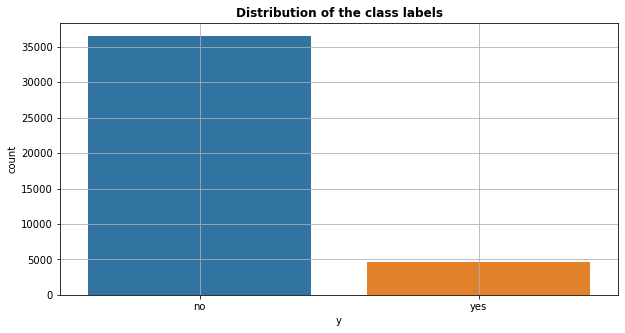

time: 242 ms (started: 2021-02-09 05:56:01 +00:00)


In [4]:
print(df_bank['y'].describe())

plt.figure(figsize=(10, 5))
sns.countplot(df_bank['y']) 
plt.grid() 
plt.title("Distribution of the class labels", weight="semibold") 
plt.show()

In [5]:
# Pick out the categorical, nominal, ordinal and numercial columns
cat_cols = np.array(['job', 'marital', 'education', 'default', 'housing', 'loan', 
                     'contact', 'month', 'day_of_week', 'poutcome', 'y'])
ord_cols = np.array(['default', 'housing', 'loan', 'contact', 'poutcome', 'y'])
nom_cols = np.setdiff1d(cat_cols, ord_cols)
num_cols = np.setdiff1d(df_bank.columns, cat_cols)
cat_cols = np.setdiff1d(cat_cols, ['y'])
ord_cols = np.setdiff1d(ord_cols, ['y'])

print("Categorical columns:", cat_cols)
print("Nominal columns:", ord_cols)
print("Ordinal columns:", nom_cols)
print("Numercial columns:", num_cols)

df_bank.info()

Categorical columns: ['contact' 'day_of_week' 'default' 'education' 'housing' 'job' 'loan'
 'marital' 'month' 'poutcome']
Nominal columns: ['contact' 'default' 'housing' 'loan' 'poutcome']
Ordinal columns: ['day_of_week' 'education' 'job' 'marital' 'month']
Numercial columns: ['age' 'campaign' 'cons.conf.idx' 'cons.price.idx' 'duration'
 'emp.var.rate' 'euribor3m' 'nr.employed' 'pdays' 'previous']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  obj

There are no missing values in the dataset.

In [6]:
for x in cat_cols:
    print("Attribute \"%s\":" % (x), df_bank[x].unique())

Attribute "contact": ['telephone' 'cellular']
Attribute "day_of_week": ['mon' 'tue' 'wed' 'thu' 'fri']
Attribute "default": ['no' 'unknown' 'yes']
Attribute "education": ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Attribute "housing": ['no' 'yes' 'unknown']
Attribute "job": ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Attribute "loan": ['no' 'yes' 'unknown']
Attribute "marital": ['married' 'single' 'divorced' 'unknown']
Attribute "month": ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Attribute "poutcome": ['nonexistent' 'failure' 'success']
time: 41.2 ms (started: 2021-02-09 05:56:01 +00:00)


In [7]:
pd.set_option('display.max_colwidth', 500) # Setting pandas to display a N number of columns

print(df_bank.shape)
display(df_bank.head(5))
display(df_bank.describe(include='all').T)
display(pd.DataFrame(df_bank.apply(lambda col: col.sort_values(ascending=True).unique()))) # unique values of each column

(41176, 21)


age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

count unique                top   freq       mean       std  \
age             41176    NaN                NaN    NaN    40.0238   10.4207   
job             41176     12             admin.  10419        NaN       NaN   
marital         41176      4            married  24921        NaN       NaN   
education       41176      8  university.degree  12164        NaN       NaN   
default         41176      3                 no  32577        NaN       NaN   
housing         41176      3                yes  21571        NaN       NaN   
loan            41176      3                 no  33938        NaN       NaN   
contact         41176      2           cellular  26135        NaN       NaN   
month           41176     10                may  13767        NaN       NaN   
day_of_week     41176      5                thu   8618        NaN       NaN   
duration        41176    NaN                NaN    NaN    258.316   259.305   
campaign        41176    NaN                NaN    NaN    2.56788   2.77032   
pdays           41176    NaN                NaN    NaN    962.465   186.937   
previous        41176    NaN                NaN    NaN   0.173013  0.494964   
poutcome        41176      3        nonexistent  35551        NaN       NaN   
emp.var.rate    41176    NaN                NaN    NaN  0.0819215   1.57088   
cons.price.idx  41176    NaN                NaN    NaN    93.5757  0.578839   
cons.conf.idx   41176    NaN                NaN    NaN   -40.5029   4.62786   
euribor3m       41176    NaN                NaN    NaN    3.62129   1.73444   
nr.employed     41176    NaN                NaN    NaN    5167.03   72.2514   
y               41176      2                 no  36537        NaN       NaN   

                   min     25%     50%     75%     max  
age                 17      32      38      47      98  
job                NaN     NaN     NaN     NaN     NaN  
marital            NaN     NaN     NaN     NaN     NaN  
education          NaN     NaN     NaN     NaN     NaN  
default            NaN     NaN     NaN     NaN     NaN  
housing            NaN     NaN     NaN     NaN     NaN  
loan               NaN     NaN     NaN     NaN     NaN  
contact            NaN     NaN     NaN     NaN     NaN  
month              NaN     NaN     NaN     NaN     NaN  
day_of_week        NaN     NaN     NaN     NaN     NaN  
duration             0     102     180     319    4918  
campaign             1       1       2       3      56  
pdays                0     999     999     999     999  
previous             0       0       0       0       7  
poutcome           NaN     NaN     NaN     NaN     NaN  
emp.var.rate      -3.4    -1.8     1.1     1.4     1.4  
cons.price.idx  92.201  93.075  93.749  93.994  94.767  
cons.conf.idx    -50.8   -42.7   -41.8   -36.4   -26.9  
euribor3m        0.634   1.344   4.857   4.961   5.045  
nr.employed     4963.6  5099.1    5191  5228.1  5228.1  
y                  NaN     NaN     NaN     NaN     NaN

0
age                                                                                                                                                                                                        [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 95, 98]
job                                                                                                                                                                                                                                                                                                                                                                                          [admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown]
marital                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        [divorced, married, single, unknown]
education                                                                                                                                                                                                                                                                                                                                                                                                                  [basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree, unknown]
default                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [no, unknown, yes]
housing                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [no, unknown, yes]
loan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [no, unknown, yes]
contact                                                                                                                                                                                                                                                                                                                                                                                           

time: 856 ms (started: 2021-02-09 05:56:01 +00:00)


<a id="eda"></a>

# EDA
[Back To Table of Contents](#top_section)

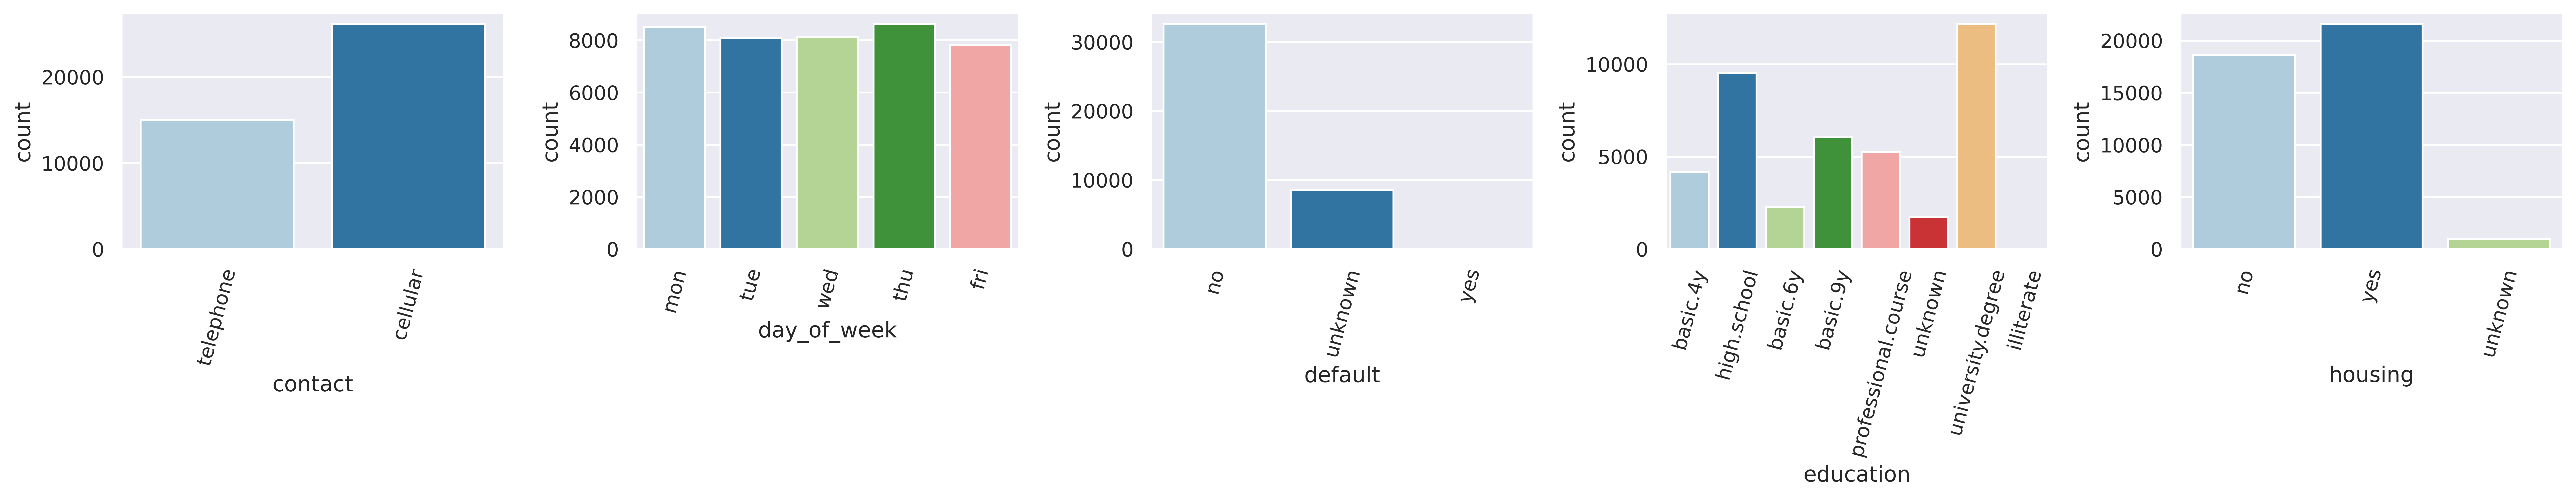

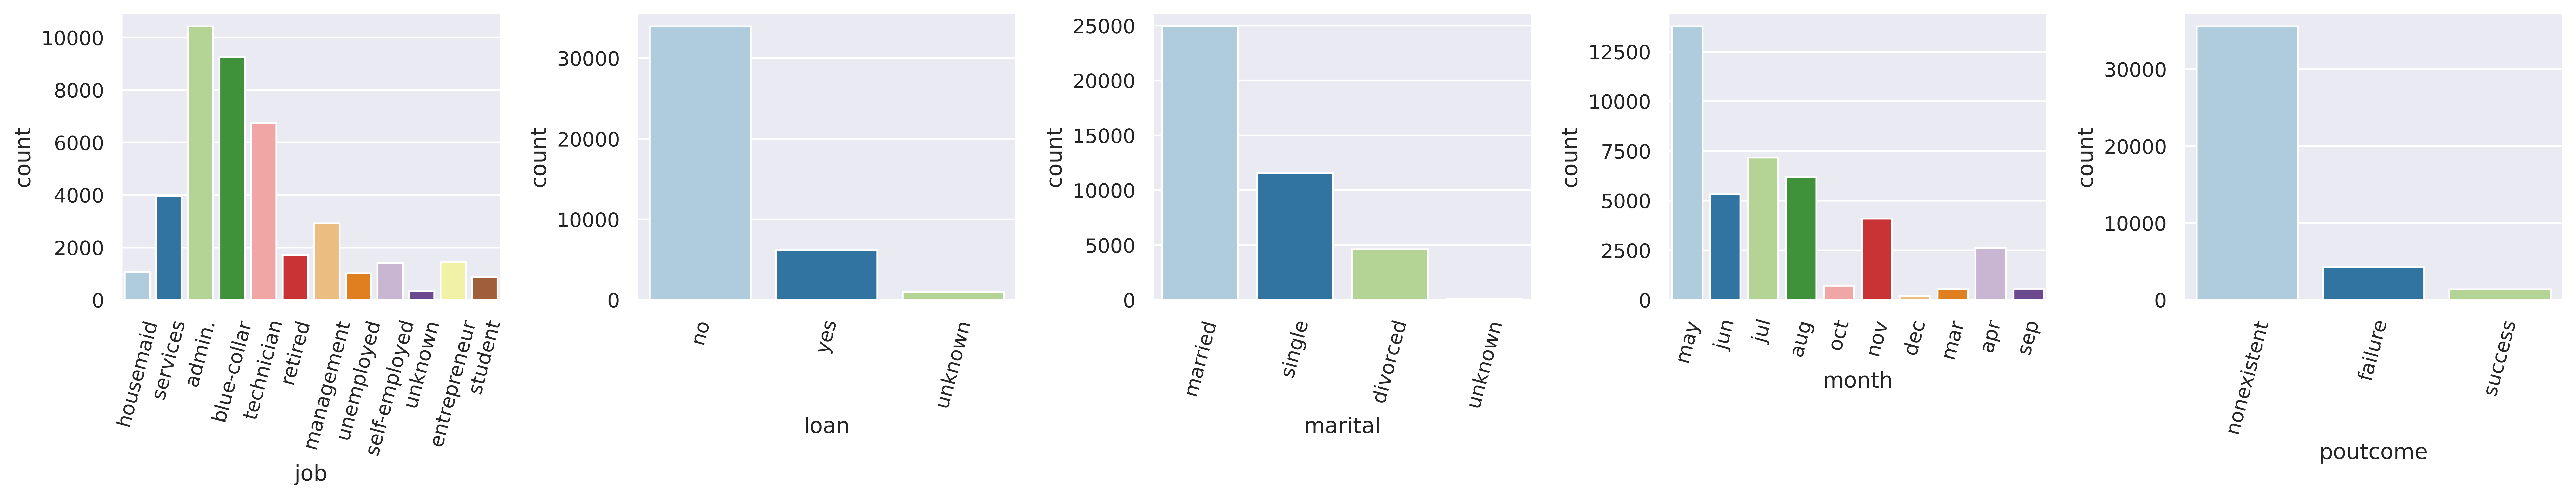

time: 6.98 s (started: 2021-02-09 05:56:02 +00:00)


In [8]:
# Plot the distribbution of categorical attributes
def chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

def histplot(df, cols, ncols):
    for lst in chunks(cols, ncols):
        sns.set(font_scale = 1)
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 4), dpi=600)
        for idx in range(0, len(lst)):
            attr = lst[idx]
            data = df[attr]
            sns.set_palette('Paired',30)
            g = sns.countplot(x=attr, data=df, ax=axes[idx])
            for item in g.get_xticklabels():
                item.set_rotation(75)
        plt.tight_layout()

histplot(df_bank[cat_cols], cat_cols, 5)

In [9]:
# Define Functions
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - 
    where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :return: float
        in the range of [0,1]
    """
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

time: 3.83 ms (started: 2021-02-09 05:56:09 +00:00)


In [10]:
def corr_matrix_plot(matrix, title="Correlation matrix between attributes"):
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(title, weight="semibold")
    ax.title.set_fontsize(10)

    # Build the Color Correlation Matrix
    mask = np.zeros_like(matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.set(font_scale = 1)
    g = sns.heatmap(matrix, cmap='Blues', fmt = '.2f', square = True, 
                  mask=mask, annot=True, annot_kws={"size":10}, linewidths=1.0)

    for text in g.texts:
        t = float(text.get_text())
        if ((t) < 0.1):
            text.set_text('')
        else:
            text.set_text(round(t, 2))

    # Build the Values Correlation Matrix
    mask[np.triu_indices_from(mask)] = False
    mask[np.tril_indices_from(mask)] = True
    g = sns.heatmap(matrix, cmap=ListedColormap(['white']), square = True, fmt = '.2f', 
                  linewidths=1.0, mask=mask, annot=True, annot_kws={"size":8}, cbar=False);
    g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right")

    # the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    print("Display first 10 pairs of features with high correlation:")
    print(matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False)[:10])

time: 4.82 ms (started: 2021-02-09 05:56:10 +00:00)


Display first 10 pairs of features with high correlation:
housing    loan        0.213874
education  job         0.196624
contact    month       0.111098
month      poutcome    0.102800
contact    poutcome    0.076342
job        marital     0.055224
           month       0.028297
education  marital     0.024057
           month       0.018037
job        poutcome    0.017779
dtype: float64


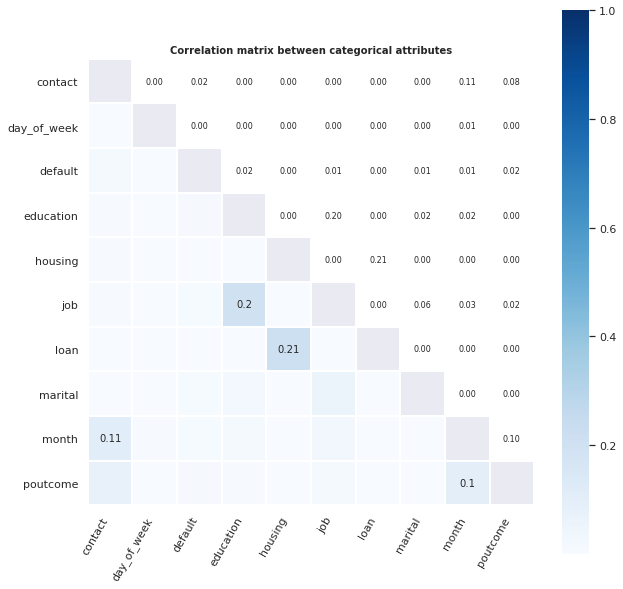

time: 5.78 s (started: 2021-02-09 05:56:10 +00:00)


In [11]:
## Correlation matrix for categorical attributes
correlationMatrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col in cat_cols:
    for row in cat_cols:
        temp = theils_u(df_bank[cat_cols][col], df_bank[cat_cols][row])
        correlationMatrix[row][col] = temp
        correlationMatrix[col][row] = temp
        
correlationMatrix = correlationMatrix.astype(float)
corr_matrix_plot(correlationMatrix, title="Correlation matrix between categorical attributes")

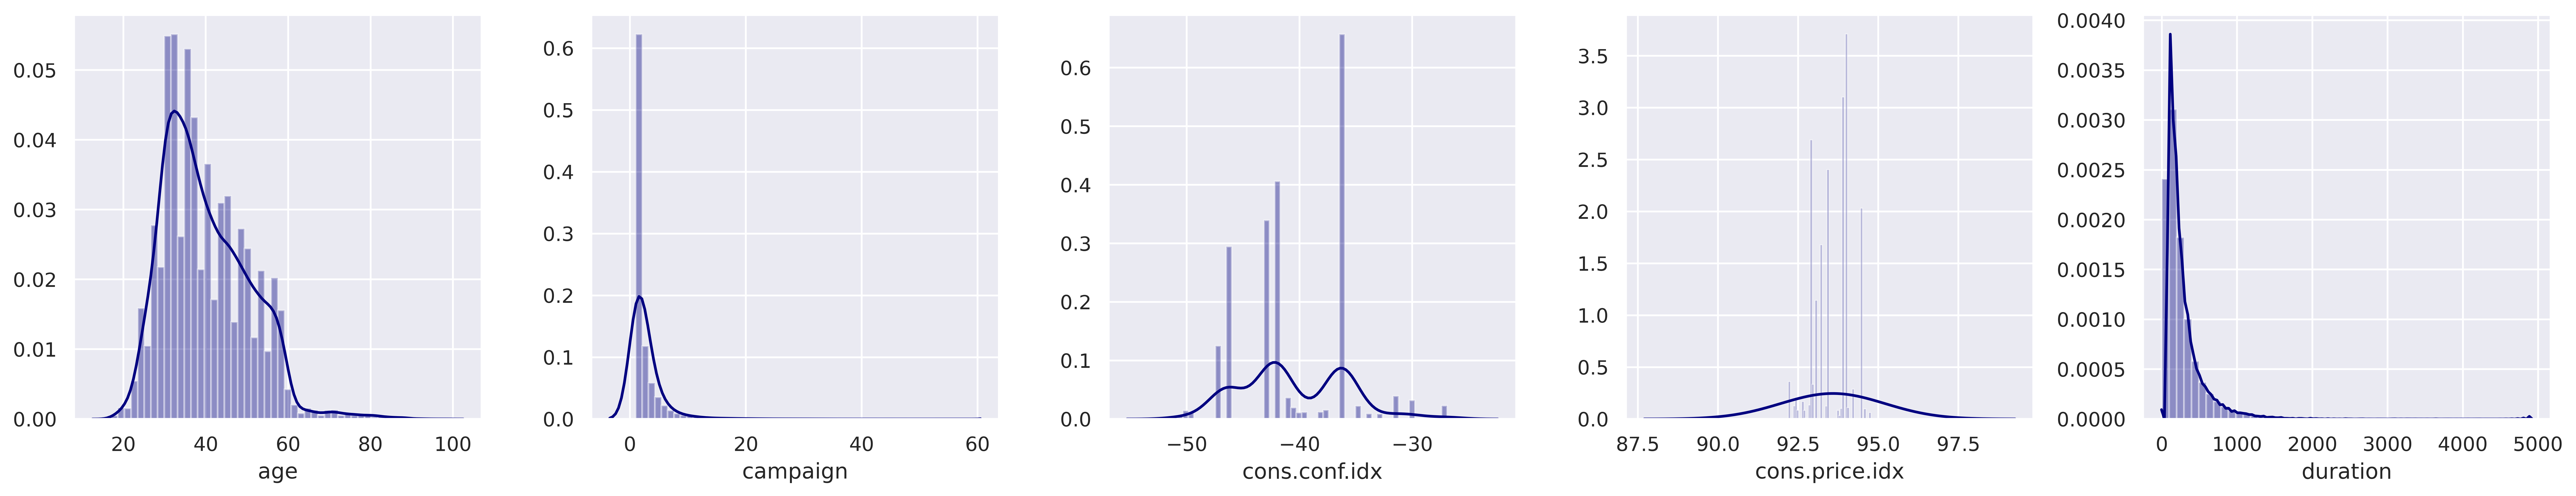

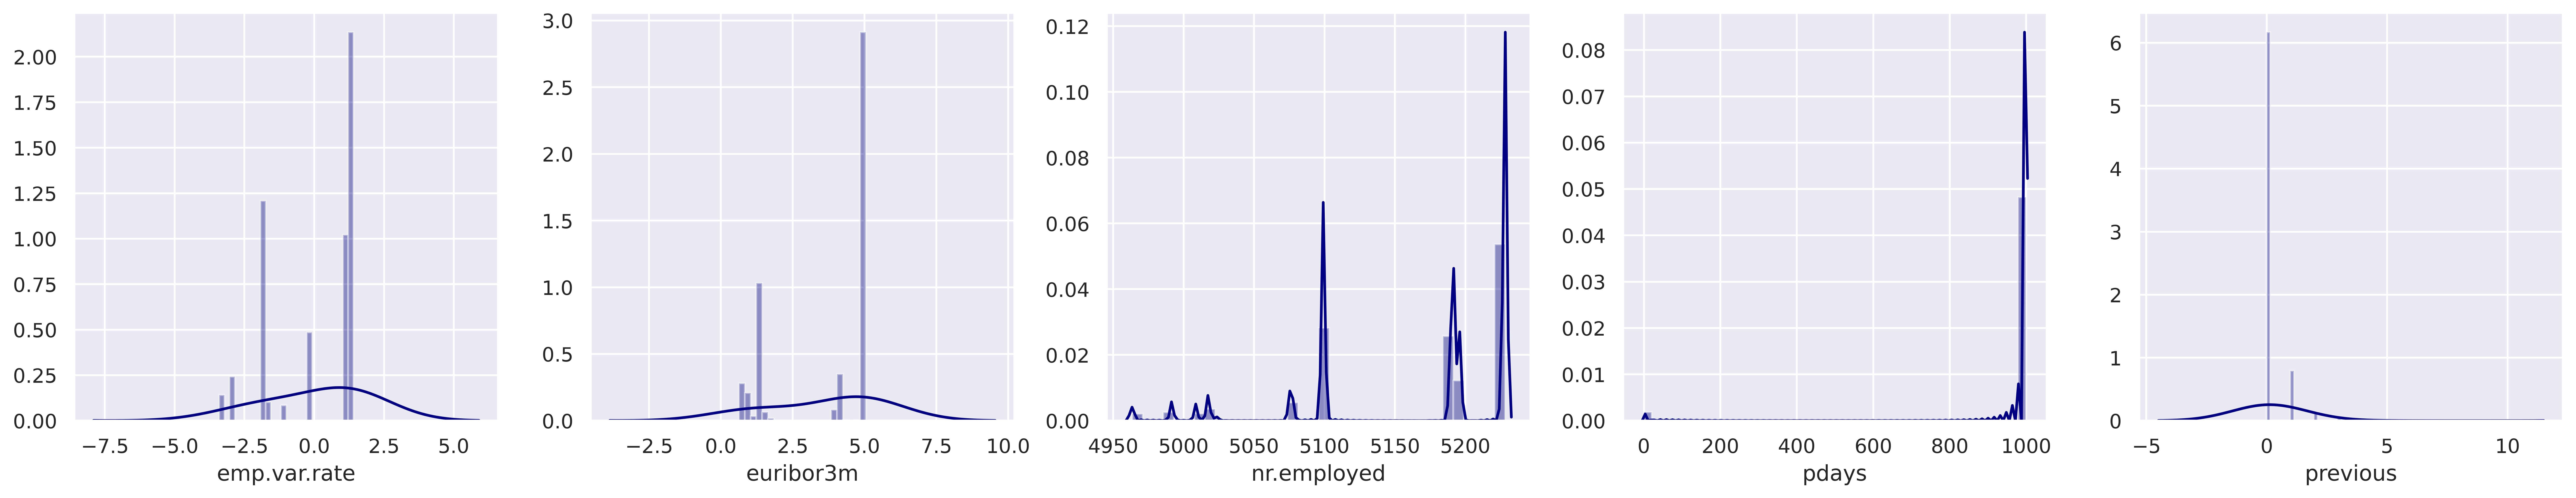

time: 9.43 s (started: 2021-02-09 05:56:16 +00:00)


In [12]:
# Plot the distribbution of numerical attributes    
def chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

def distplot(df, cols, ncols):
    for lst in chunks(cols, ncols):
        sns.set(font_scale = 1)
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 4), dpi=600)
        for idx in range(0, len(lst)):
            attr = lst[idx]
            data = df[attr]
            g = sns.distplot(data.dropna(), color='navy', ax=axes[idx], kde_kws={'bw': 1.5})
        plt.tight_layout()

distplot(df_bank[num_cols], num_cols, 5)

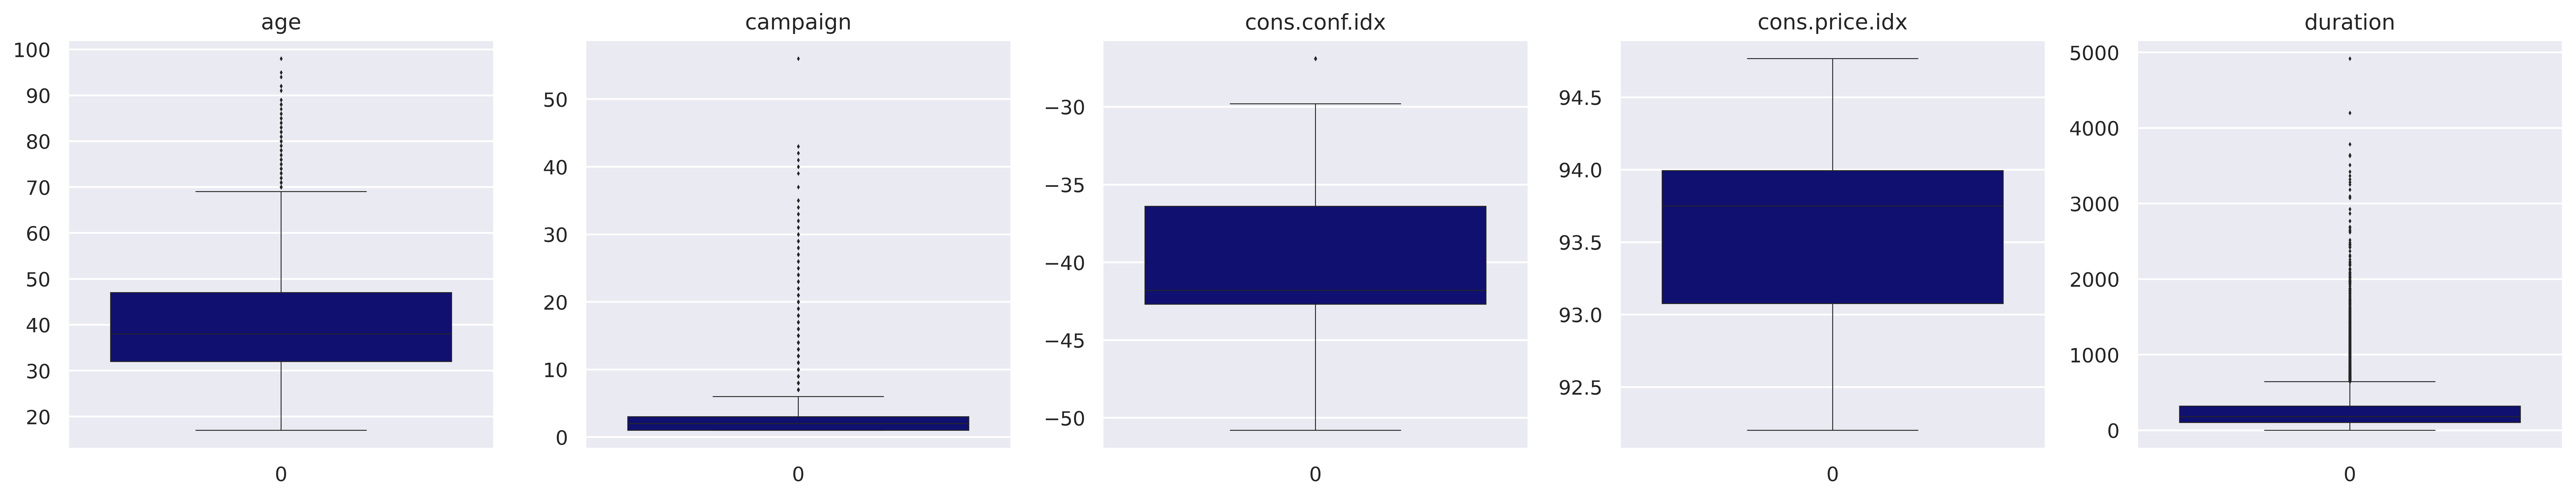

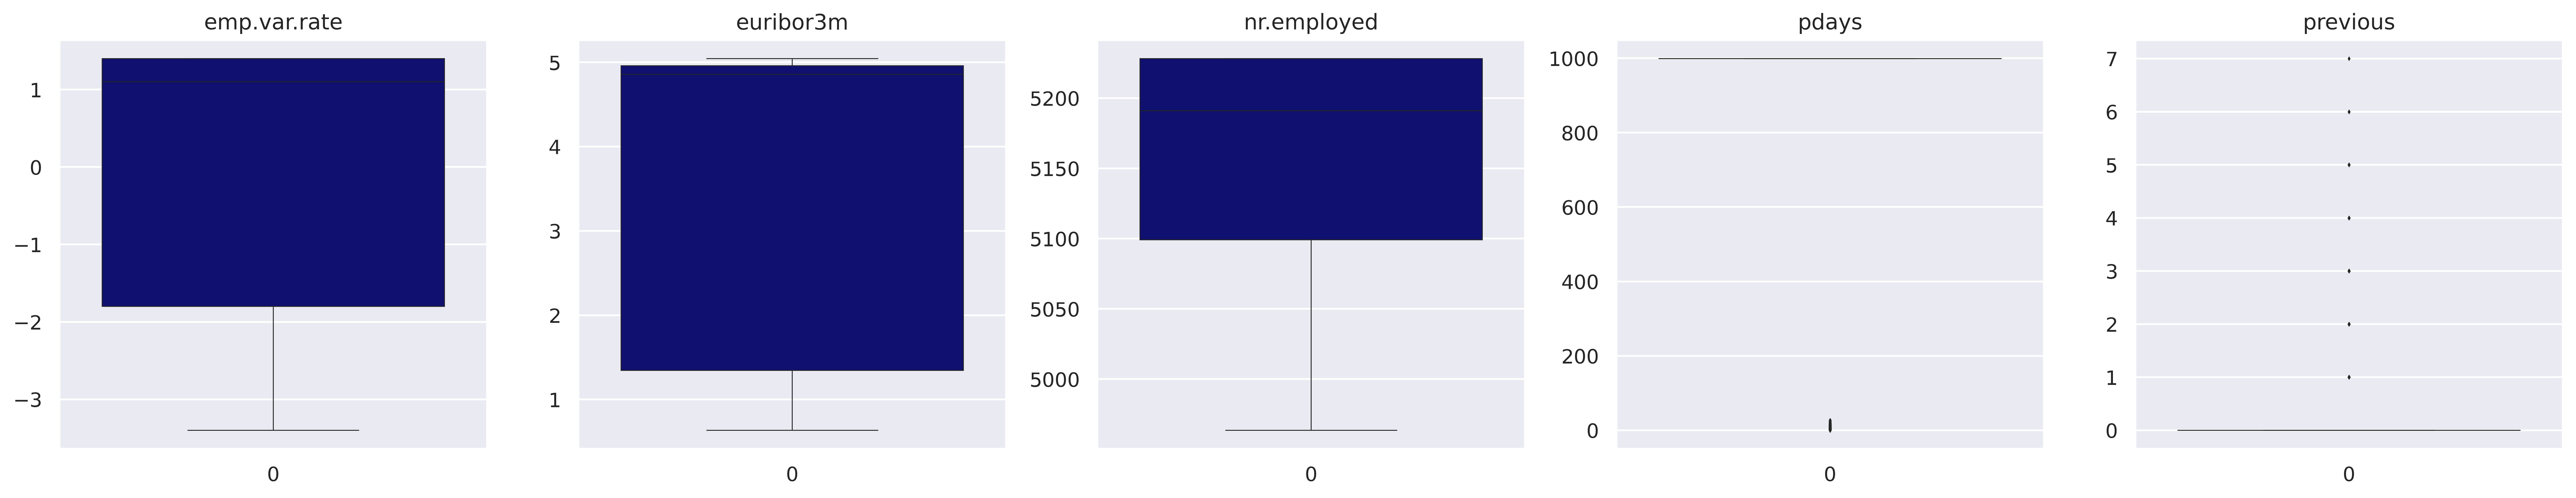

time: 5.55 s (started: 2021-02-09 05:56:26 +00:00)


In [13]:
# Plot the boxplot of each attribute 
def chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

def boxplot(df, cols, ncols):
    for lst in chunks(cols, ncols):
        sns.set(font_scale = 1)
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 4), dpi=600)
        for idx in range(0, len(lst)):
            attr = lst[idx]
            data = df[attr]
            sns.set_palette('Paired',30)
            g = sns.boxplot(data=df[attr], ax=axes[idx], fliersize=0.5, linewidth=0.5, color='navy').set_title(attr)
        plt.tight_layout()

boxplot(df_bank[num_cols], num_cols, 5)

Display first 10 pairs of features with high correlation:
emp.var.rate    euribor3m       0.972244
euribor3m       nr.employed     0.945146
emp.var.rate    nr.employed     0.906949
cons.price.idx  emp.var.rate    0.775293
                euribor3m       0.688180
                nr.employed     0.521945
nr.employed     pdays           0.372659
euribor3m       pdays           0.296946
cons.conf.idx   euribor3m       0.277864
emp.var.rate    pdays           0.271063
dtype: float64


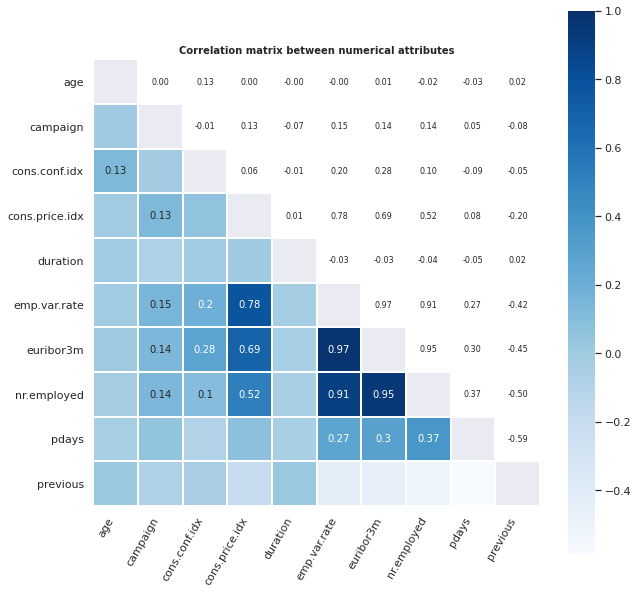

time: 745 ms (started: 2021-02-09 05:56:31 +00:00)


In [14]:
## CORRELATION MATRIX FOR NUMERICAL ATTRIBUTES

correlationMatrix = df_bank[num_cols].dropna().corr()
corr_matrix_plot(correlationMatrix, title="Correlation matrix between numerical attributes")

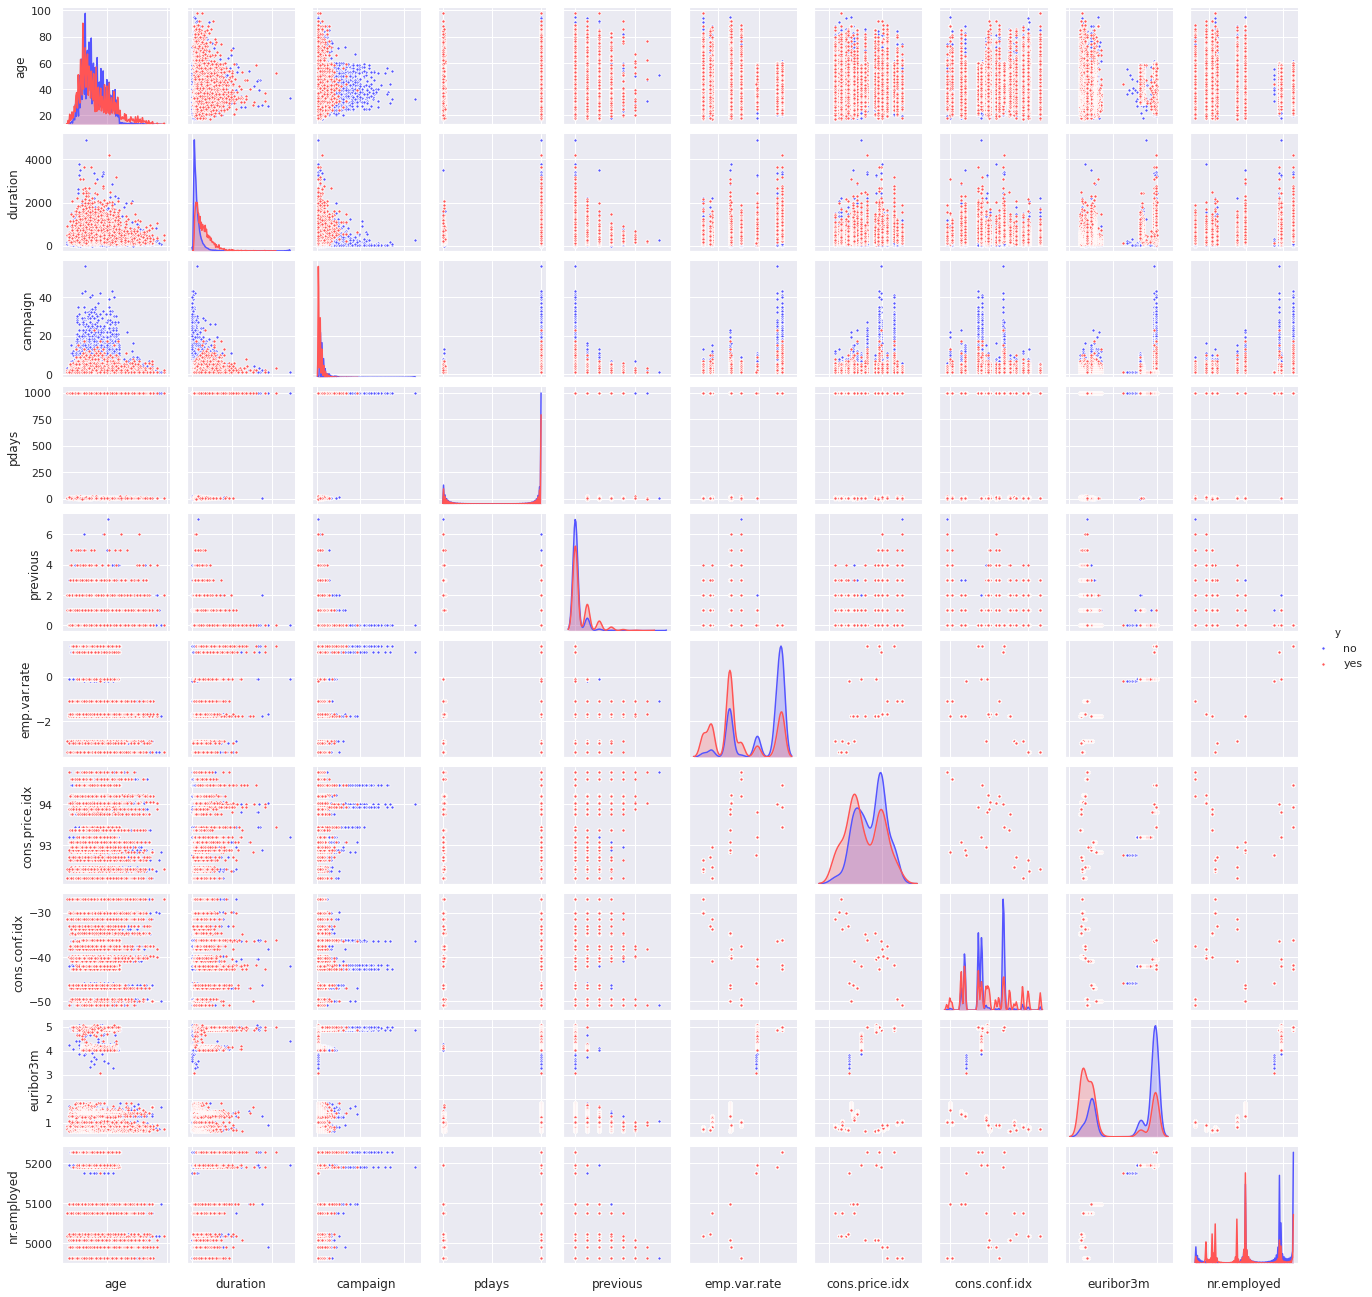

time: 55.4 s (started: 2021-02-09 05:56:32 +00:00)


In [15]:
g = sns.pairplot(df_bank, hue='y', palette = 'seismic', size=1.8, diag_kind = 'kde', 
                 plot_kws=dict(s=10), diag_kws={'bw': 0.2, 'shade': True})
g.set(xticklabels=[])

<a id="Feature_Engineering"></a>

# Feature Engineering
[Back To Table of Contents](#top_section)

In [16]:
# convert the ordinal to numerical 
for x in ord_cols:
    print(x, df_bank[x].unique())

df_bank['contact'].replace({'telephone':0, 'cellular':1}, inplace=True)
df_bank['default'].replace({'no':-1, 'unknown':0, 'yes':1}, inplace=True)
df_bank['housing'].replace({'no':-1, 'unknown':0, 'yes':1}, inplace=True)
df_bank['loan'].replace({'no':-1, 'unknown':0, 'yes':1}, inplace=True)
df_bank['poutcome'].replace({'failure':-1, 'nonexistent':0, 'success':1}, inplace=True)

for x in ord_cols:
    print(x, df_bank[x].unique())

contact ['telephone' 'cellular']
default ['no' 'unknown' 'yes']
housing ['no' 'yes' 'unknown']
loan ['no' 'yes' 'unknown']
poutcome ['nonexistent' 'failure' 'success']
contact [0 1]
default [-1  0  1]
housing [-1  1  0]
loan [-1  1  0]
poutcome [ 0 -1  1]
time: 223 ms (started: 2021-02-09 05:57:28 +00:00)


In [17]:
TEST_SIZE = 0.3
RAND = 42
earlystopping = 50

X_temp = df_bank.drop(['y'], axis=1)
y_temp = df_bank['y'].replace({'yes':1, 'no':0})

X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, 
                                                    test_size = TEST_SIZE, 
                                                    random_state=RAND)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train.head())

(28823, 20)

(12353, 20)

(28823,)

(12353,)

age           job   marital          education  default  housing  loan  \
7108    59  entrepreneur   married           basic.9y       -1       -1    -1   
31608   31   blue-collar   married           basic.9y       -1        1    -1   
21647   32        admin.    single  university.degree       -1        0     0   
24600   42        admin.  divorced        high.school       -1        0     0   
31475   44    unemployed   married           basic.9y       -1        1    -1   

       contact month day_of_week  duration  campaign  pdays  previous  \
7108         0   may         thu       200         4    999         0   
31608        1   may         thu      1957         1    999         0   
21647        1   aug         tue        40         1    999         0   
24600        1   nov         mon       295         2    999         1   
31475        1   may         wed       206         2    999         0   

       poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
7108          0           1.1          93.994          -36.4      4.860   
31608         0          -1.8          92.893          -46.2      1.327   
21647         0           1.4          93.444          -36.1      4.963   
24600        -1          -0.1          93.200          -42.0      4.191   
31475         0          -1.8          92.893          -46.2      1.334   

       nr.employed  
7108        5191.0  
31608       5099.1  
21647       5228.1  
24600       5195.8  
31475       5099.1

time: 101 ms (started: 2021-02-09 05:57:29 +00:00)


For the other catergorical features, we will use the Weight of Evidence Encoder to transform to numerical. 

<a id="Init_exp"></a>

# Initial Experiment
[Back To Table of Contents](#top_section)

In [18]:
def transform_values(df):
    return df.values

time: 908 µs (started: 2021-02-09 05:57:30 +00:00)


Training dataset after WOE encoder and SMOTE:


(51216, 20)

age       job   marital  education  default  housing  loan  contact  \
0  59.0 -0.372152 -0.132608  -0.406788     -1.0     -1.0  -1.0      0.0   
1  31.0 -0.506706 -0.132608  -0.406788     -1.0      1.0  -1.0      1.0   
2  32.0  0.161530  0.269172   0.222269     -1.0      0.0   0.0      1.0   
3  42.0  0.161530 -0.067952  -0.006930     -1.0      0.0   0.0      1.0   
4  44.0  0.214952 -0.132608  -0.406788     -1.0      1.0  -1.0      1.0   

      month  day_of_week  duration  campaign  pdays  previous  poutcome  \
0 -0.620540     0.087974     200.0       4.0  999.0       0.0       0.0   
1 -0.620540     0.087974    1957.0       1.0  999.0       0.0       0.0   
2 -0.110096     0.060230      40.0       1.0  999.0       0.0       0.0   
3 -0.123852    -0.157809     295.0       2.0  999.0       1.0      -1.0   
4 -0.620540     0.023635     206.0       2.0  999.0       0.0       0.0   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0           1.1          93.994          -36.4      4.860       5191.0  
1          -1.8          92.893          -46.2      1.327       5099.1  
2           1.4          93.444          -36.1      4.963       5228.1  
3          -0.1          93.200          -42.0      4.191       5195.8  
4          -1.8          92.893          -46.2      1.334       5099.1

Decision Tree accuracy for train: 1.000: test: 0.884
Decision Tree precision for train: 1.000: test: 0.498
Decision Tree AUC for train: 1.000: test: 0.741
Decision Tree F1 score for train: 1.000: test: 0.730
Decision Tree F-Beta 0.5 score for train: 1.000: test: 0.723
Decision Tree Matthews correlation coefficient for train: 1.000: test: 0.460
Feature importances (Decision Tree):


duration  nr.employed   contact  cons.conf.idx     month  \
Decision Tree   0.40138     0.142994  0.092119       0.055018  0.040575   

               day_of_week  euribor3m      age  education  cons.price.idx  \
Decision Tree      0.03782   0.030969  0.02929   0.028163        0.026249   

               campaign       job  emp.var.rate   marital   housing  poutcome  \
Decision Tree   0.02011  0.018808      0.015776  0.014118  0.013114  0.011433   

               previous      loan   default     pdays  
Decision Tree  0.007177  0.006518  0.004682  0.003687

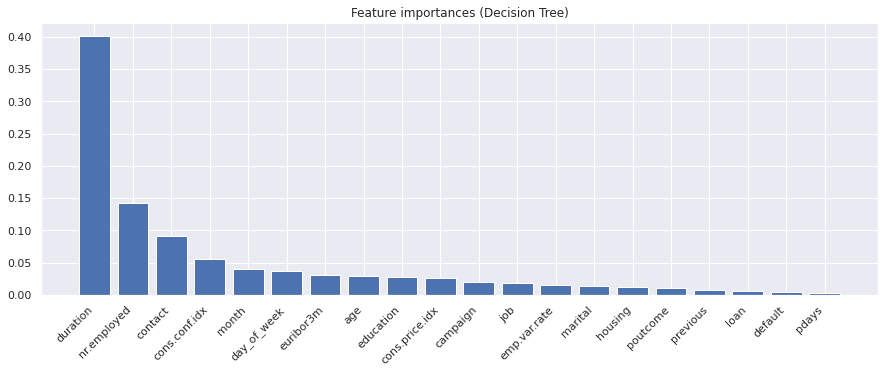

time: 1.83 s (started: 2021-02-09 05:57:31 +00:00)


In [19]:
# The initial experiment on columns transformation, SMOTE for imbalanced classifcation and Decision Trees
WOE_encoder = WOEEncoder(cols = nom_cols)
WOE_encoder.fit(X_train, y_train)
X_train_woe = WOE_encoder.transform(X_train, y_train).values
X_test_woe = WOE_encoder.transform(X_test, y_test).values

sm = SMOTE(random_state=RAND)
X_train_woe_SMOTE, y_train_woe_SMOTE = sm.fit_resample(X_train_woe, y_train)

print("Training dataset after WOE encoder and SMOTE:")
display(X_train_woe_SMOTE.shape)
display(pd.DataFrame(X_train_woe_SMOTE, columns=X_train.columns).head())

dec_tree = tree.DecisionTreeClassifier()
dec_tree.fit(X_train_woe_SMOTE, y_train_woe_SMOTE.squeeze())

#calculate and print scores for the model for top 15 features
y_train_preds = dec_tree.predict(X_train_woe_SMOTE)
y_test_preds = dec_tree.predict(X_test_woe)

print('Decision Tree accuracy for train: %.3f: test: %.3f' % (accuracy_score(y_train_woe_SMOTE, y_train_preds), 
                                                              accuracy_score(y_test, y_test_preds)))
print('Decision Tree precision for train: %.3f: test: %.3f' % (precision_score(y_train_woe_SMOTE, y_train_preds), 
                                                              precision_score(y_test, y_test_preds)))
print('Decision Tree AUC for train: %.3f: test: %.3f' % (roc_auc_score(y_train_woe_SMOTE, y_train_preds), 
                                                         roc_auc_score(y_test, y_test_preds)))
print('Decision Tree F1 score for train: %.3f: test: %.3f' % (f1_score(y_train_woe_SMOTE, y_train_preds, average='macro'), 
                                                              f1_score(y_test, y_test_preds, average='macro')))
print('Decision Tree F-Beta 0.5 score for train: %.3f: test: %.3f' % (fbeta_score(y_train_woe_SMOTE, y_train_preds, average='macro', beta=0.5), 
                                                                      fbeta_score(y_test, y_test_preds, average='macro', beta=0.5)))
print('Decision Tree Matthews correlation coefficient for train: %.3f: test: %.3f' % (matthews_corrcoef(y_train_woe_SMOTE, y_train_preds), 
                                                                                      matthews_corrcoef(y_test, y_test_preds)))

#get feature importances from the model
dc_feature_importances_ = pd.DataFrame(dec_tree.feature_importances_, index = X_train.columns, 
                                       columns=["Decision Tree"]).sort_values(by="Decision Tree", ascending=False)

print("Feature importances (Decision Tree):")
display(dc_feature_importances_.T)

#plot feature importances
plt.figure(figsize=(15, 5))
x_pos = np.arange(0, len(dc_feature_importances_))
plt.bar(x_pos, dc_feature_importances_["Decision Tree"])
plt.xticks(x_pos, dc_feature_importances_.index, rotation=45, ha="right")
plt.title("Feature importances (Decision Tree)")
plt.show()

In [20]:
# Implement the transformation pipeline, StratifiedKFold cv and Decision Trees
imba_pipeline = Pipeline([("WOEEncoder", WOEEncoder(cols = nom_cols)), 
                          ("ValueTrans", FunctionTransformer(transform_values)),
                          ("SMOTE", SMOTE(random_state=RAND, n_jobs=-1)), 
                          ("model", tree.DecisionTreeClassifier())
                         ])

skf = StratifiedKFold(n_splits=5, random_state=RAND, shuffle=True)

cross_validate(imba_pipeline, X_train, y_train, n_jobs=-1, scoring="f1_macro", cv=skf)

{'fit_time': array([1.01073194, 1.00909638, 0.98806763, 0.99076247, 0.72729182]),
 'score_time': array([0.02449989, 0.02304339, 0.02492571, 0.02544928, 0.01741791]),
 'test_score': array([0.72691962, 0.71100091, 0.72740543, 0.72801018, 0.73327148])}

time: 5.17 s (started: 2021-02-09 05:57:33 +00:00)


In [21]:
# Implement the transformation pipeline, StratifiedKFold cv, Decision Trees with gridsearch
imba_pipeline = Pipeline([("WOEEncoder", WOEEncoder(cols = nom_cols)), 
                          ("ValueTrans", FunctionTransformer(transform_values)),
                          ("SMOTE", SMOTE(random_state=RAND, n_jobs=-1)), 
                          ("model", tree.DecisionTreeClassifier())
                         ])

param_grid = {"model__max_depth": [16, 18, 20], 
              "model__criterion": ["gini", "entropy"],
              "model__min_samples_leaf": [5, 50, 100],
              "model__min_samples_split": [2, 3, 4]
             }

skf = StratifiedKFold(n_splits=5, random_state=RAND, shuffle=True)

grid_imba = GridSearchCV(estimator=imba_pipeline, param_grid=param_grid, 
                         n_jobs=-1, pre_dispatch='2*n_jobs',cv=skf, 
                         scoring="f1_macro", refit='f1_macro', return_train_score=True
                         )

grid_imba.fit(X_train, y_train)
print(grid_imba.best_params_, grid_imba.best_score_)

y_test_predict = grid_imba.predict(X_test)
print(accuracy_score(y_test, y_test_predict))
print(precision_score(y_test, y_test_predict))
print(roc_auc_score(y_test, y_test_predict))
print(f1_score(y_test, y_test_predict, average='macro'))
print(fbeta_score(y_test, y_test_predict, average='macro', beta=0.5))
print(matthews_corrcoef(y_test, y_test_predict))

{'model__criterion': 'gini', 'model__max_depth': 16, 'model__min_samples_leaf': 50, 'model__min_samples_split': 4} 0.768869975601595
0.8910386141018376
0.5190058479532164
0.828791537256305
0.774686227394957
0.7531837025594452
0.5642446659886303
time: 2min 36s (started: 2021-02-09 05:57:39 +00:00)


In [22]:
def batch_classify(X_train, Y_train, X_test, Y_test, dict_models, 
                   dict_classifiers, pipeline_list, no_classifiers = 1, verbose = True):
    """
    This function take input data, pipeline and list of classifiers and its hyperparameters. 
    Then store the trained models into list, which could be reused later or export to file for further uses. 
    """
    
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.time()
        if verbose:
            print("Start {c} at {ct}".format(c=classifier_name, ct=time.ctime()))
        
        # pipeline: 
        temp_pipeline_list = pipeline_list.copy()
        temp_pipeline_list.append(("SMOTE", SMOTE(random_state=RAND, n_jobs=-1))) 
        temp_pipeline_list.append(("model", classifier.get("model")))
        imba_pipeline = Pipeline(temp_pipeline_list)

        # get param grid
        new_params = {'model__' + key: classifier.get("param_grid")[key] for key in classifier.get("param_grid")}
        
        # params for XGBoost and LightGBM early stopping
        if (classifier_name == "XGB") or (classifier_name == "LightGBM"):
            eval_pipe = Pipeline(pipeline_list)
            eval_pipe.fit(X_train, Y_train)
            X_test_val = eval_pipe.transform(X_test)
            if classifier_name == "XGB":
                fit_params = {"model__early_stopping_rounds": earlystopping, "model__verbose": False,
                              "model__eval_set": [[X_test_val, Y_test]]}
            else:
                fit_params = {"model__early_stopping_rounds": earlystopping, "model__verbose": False, 
                              "model__eval_set": (X_test_val, Y_test)}
        else:
            fit_params = {}
        
        # Stratified K-Folds Cross-Validation
        skf = StratifiedKFold(n_splits=5, random_state=RAND, shuffle=True)
        
        # GrivSearchCV to find best parameters 
        grid_imba = GridSearchCV(estimator=imba_pipeline, param_grid=new_params, n_jobs=-1, pre_dispatch='2*n_jobs',
                                 cv=skf, scoring="f1_macro", refit="f1_macro", return_train_score=True)
        grid_imba.fit(X_train, Y_train, **fit_params)        
        Y_train_preds = grid_imba.predict(X_train)
        Y_test_preds = grid_imba.predict(X_test)

        t_end = time.time()
        t_diff = (t_end - t_start)/60
        
        # scoring and update dict_models
        dict_models[classifier_name] = {'model': grid_imba.best_estimator_,
                                        'train_accuracy': accuracy_score(Y_train, Y_train_preds), 
                                        'test_accuracy': accuracy_score(Y_test, Y_test_preds), 
                                        'train_precision': precision_score(Y_train, Y_train_preds, average='macro'), 
                                        'test_precision': precision_score(Y_test, Y_test_preds, average='macro'), 
                                        'train_roc_auc': roc_auc_score(Y_train, Y_train_preds, average='macro'), 
                                        'test_roc_auc':roc_auc_score(Y_test, Y_test_preds, average='macro'),
                                        'train_mcc':matthews_corrcoef(Y_train, Y_train_preds), 
                                        'test_mcc':matthews_corrcoef(Y_test, Y_test_preds), 
                                        'train_fbeta':fbeta_score(Y_train, Y_train_preds, average='macro', beta=0.5), 
                                        'test_fbeta':fbeta_score(Y_test, Y_test_preds, average='macro', beta=0.5), 
                                        'train_f1':f1_score(Y_train, Y_train_preds, average='macro'), 
                                        'test_f1':f1_score(Y_test, Y_test_preds, average='macro'), 
                                        'train_time': t_diff}

        if verbose:
            print("Trained {c} in {f:.2f} min and finished at {ct}".format(c=classifier_name, f=t_diff, ct=time.ctime()))
    return dict_models

time: 8.66 ms (started: 2021-02-09 06:00:16 +00:00)


In [23]:
def export_dict_models(dict_models, sort_by='test_f1'):
    cls = [key for key in dict_models.keys()]
    
    training_acc = [dict_models[key]['train_accuracy'] for key in cls]
    test_acc = [dict_models[key]['test_accuracy'] for key in cls]
    training_pre = [dict_models[key]['train_precision'] for key in cls]
    test_pre = [dict_models[key]['test_precision'] for key in cls]
    training_roc = [dict_models[key]['train_roc_auc'] for key in cls]
    test_roc = [dict_models[key]['test_roc_auc'] for key in cls]
    training_mcc = [dict_models[key]['train_mcc'] for key in cls]
    test_mcc = [dict_models[key]['test_mcc'] for key in cls]
    training_fb = [dict_models[key]['train_fbeta'] for key in cls]
    test_fb = [dict_models[key]['test_fbeta'] for key in cls]
    training_f1 = [dict_models[key]['train_f1'] for key in cls]
    test_f1 = [dict_models[key]['test_f1'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]

    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),14)), columns = ['classifier', 
                                                                     'train_accuracy', 'test_accuracy', 
                                                                     'train_precision', 'test_precision', 
                                                                     'train_roc_auc', 'test_roc_auc', 'train_mcc', 'test_mcc', 
                                                                     'train_fbeta', 'test_fbeta', 'train_f1', 'test_f1',
                                                                     'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_accuracy'] = training_acc[ii]
        df_.loc[ii, 'test_accuracy'] = test_acc[ii]
        df_.loc[ii, 'train_precision'] = training_pre[ii]
        df_.loc[ii, 'test_precision'] = test_pre[ii]
        df_.loc[ii, 'train_roc_auc'] = training_roc[ii]
        df_.loc[ii, 'test_roc_auc'] = test_roc[ii]
        df_.loc[ii, 'train_mcc'] = training_mcc[ii]
        df_.loc[ii, 'test_mcc'] = test_mcc[ii]
        df_.loc[ii, 'train_fbeta'] = training_fb[ii]
        df_.loc[ii, 'test_fbeta'] = test_fb[ii]
        df_.loc[ii, 'train_f1'] = training_f1[ii]
        df_.loc[ii, 'test_f1'] = test_f1[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    return df_.sort_values(by=sort_by, ascending=False)

time: 8.02 ms (started: 2021-02-09 06:00:16 +00:00)


<a id="basic_classifiers"></a>

# Some Basic Classifiers
[Back To Table of Contents](#top_section)

In [24]:
# Set up models and grid parameters 
dict_classifiers = {
        "Logistic Regression": {"model": LogisticRegression(random_state=RAND), 
                                "param_grid": {"C": [0.3, 0.6, 0.7], "penalty": ["l1","l2"], 
                                               "solver": ["saga"]
                                              }
                               },
        "Nearest Neighbors": {"model": KNeighborsClassifier(), 
                              "param_grid": {"n_neighbors": [21, 23, 25]}
                             },
#         "Linear SVM": {"model": SVC(), 
#                         "param_grid": {'gamma':[0.1, 0.001]}
#                       },
        "Naive Bayes": {"model": GaussianNB(), 
                        "param_grid": {"var_smoothing": np.logspace(0,-9, num=10)}
                       },
        "Neural Net": {"model": MLPClassifier(random_state=RAND, early_stopping=True),
                        "param_grid": {"alpha": [0.00001, 0.000001], 
                                       "activation": ["tanh"], # "relu"], 
                                       "hidden_layer_sizes": [(10, 150, 10), (10, 180, 10)]
                                      }
                      },
        "QDA": {"model": QuadraticDiscriminantAnalysis(), 
                        "param_grid": {"reg_param": (0.01, 0.1), "store_covariance": (True, False), 
                                       "tol": (0.01, 0.1)}
               },
        "Decision Tree": {"model": tree.DecisionTreeClassifier(random_state=RAND), 
                          "param_grid": {"max_depth": [16, 18, 20], 
                                         "criterion": ["gini", "entropy"],
                                         "min_samples_leaf": [5, 50, 100],
                                         "min_samples_split": [2, 3, 4]}
                         },
}

# Train and compare with multiple models
dict_models = {}
imba_pipeline_list = [("WOEEncoder", WOEEncoder(cols = nom_cols)), 
                      ("ValueTrans", FunctionTransformer(transform_values)), 
                      ("StandardScaler", StandardScaler()),
                     ]

batch_classify(X_train, y_train, X_test, y_test, dict_models, dict_classifiers, imba_pipeline_list, no_classifiers = 6)
models_comp = export_dict_models(dict_models)
display(models_comp)

Start Logistic Regression at Tue Feb  9 06:00:17 2021
Trained Logistic Regression in 0.32 min and finished at Tue Feb  9 06:00:37 2021
Start Nearest Neighbors at Tue Feb  9 06:00:37 2021
Trained Nearest Neighbors in 5.77 min and finished at Tue Feb  9 06:06:23 2021
Start Naive Bayes at Tue Feb  9 06:06:23 2021
Trained Naive Bayes in 0.30 min and finished at Tue Feb  9 06:06:41 2021
Start Neural Net at Tue Feb  9 06:06:41 2021
Trained Neural Net in 8.83 min and finished at Tue Feb  9 06:15:30 2021
Start QDA at Tue Feb  9 06:15:30 2021
Trained QDA in 0.27 min and finished at Tue Feb  9 06:15:47 2021
Start Decision Tree at Tue Feb  9 06:15:47 2021
Trained Decision Tree in 2.84 min and finished at Tue Feb  9 06:18:37 2021


classifier  train_accuracy  test_accuracy  train_precision  \
5        Decision Tree        0.897582       0.881324         0.752465   
0  Logistic Regression        0.868265       0.862463         0.718136   
4                  QDA        0.878118       0.877682         0.714773   
3           Neural Net        0.862575       0.853882         0.717515   
1    Nearest Neighbors        0.857440       0.836396         0.715310   
2          Naive Bayes        0.883808       0.881405         0.709653   

   test_precision  train_roc_auc  test_roc_auc  train_mcc  test_mcc  \
5        0.731373       0.877084      0.846510   0.617091  0.566297   
0        0.713958       0.873369      0.859364   0.570772  0.554577   
4        0.719310       0.802212      0.803531   0.509538  0.516014   
3        0.710698       0.893558      0.876501   0.585166  0.563305   
1        0.692492       0.901820      0.854710   0.588272  0.522604   
2        0.710702       0.723137      0.717993   0.432580  0.428634   

   train_fbeta  test_fbeta  train_f1   test_f1  train_time  
5     0.766097    0.743415  0.794759  0.769454    2.843489  
0     0.729652    0.724801  0.759811  0.753263    0.320061  
4     0.725199    0.729566  0.746200  0.750005    0.266204  
3     0.728165    0.720312  0.759680  0.749773    8.825782  
1     0.725039    0.699814  0.756678  0.726519    5.765380  
2     0.712143    0.712098  0.716065  0.714249    0.302100

time: 18min 20s (started: 2021-02-09 06:00:17 +00:00)


In [25]:
display(dict_models)

{'Logistic Regression': {'model': Pipeline(steps=[('WOEEncoder',
                   WOEEncoder(cols=['day_of_week', 'education', 'job', 'marital',
                                    'month'])),
                  ('ValueTrans',
                   FunctionTransformer(func=<function transform_values at 0x7f654f21b5f0>)),
                  ('StandardScaler', StandardScaler()),
                  ('SMOTE', SMOTE(n_jobs=-1, random_state=42)),
                  ('model',
                   LogisticRegression(C=0.3, random_state=42, solver='saga'))]),
  'train_accuracy': 0.8682649273149915,
  'test_accuracy': 0.8624625597020966,
  'train_precision': 0.7181364407025026,
  'test_precision': 0.713957923081967,
  'train_roc_auc': 0.8733686146387962,
  'test_roc_auc': 0.859364028391631,
  'train_mcc': 0.5707724613795985,
  'test_mcc': 0.5545765272531552,
  'train_fbeta': 0.7296515967090647,
  'test_fbeta': 0.7248012577445304,
  'train_f1': 0.759811446127229,
  'test_f1': 0.7532626464851699,
  'trai

time: 56.2 ms (started: 2021-02-09 06:18:38 +00:00)


<a id="voting_classifiers"></a>

# Voting Classifiers
[Back To Table of Contents](#top_section)

In [26]:
cls = [key for key in dict_models.keys()]
voting_list = [(key, dict_models[key]['model']['model']) for key in cls]

dict_classifiers = {
        "Voting Hard Classifiers": {"model": VotingClassifier(estimators=voting_list, n_jobs=-1), 
                                    "param_grid": {'voting': ['hard']}
                                   },
        "Voting Soft Classifiers": {"model": VotingClassifier(estimators=voting_list, n_jobs=-1), 
                                    "param_grid": {'voting': ['soft']}
                                   },
}

imba_pipeline_list = [("WOEEncoder", WOEEncoder(cols = nom_cols)), 
                      ("ValueTrans", FunctionTransformer(transform_values)), 
                      ("StandardScaler", StandardScaler()),
                     ]

batch_classify(X_train, y_train, X_test, y_test, dict_models, dict_classifiers, imba_pipeline_list, no_classifiers = 2)
models_comp = export_dict_models(dict_models)
display(models_comp)

Start Voting Hard Classifiers at Tue Feb  9 06:18:39 2021
Trained Voting Hard Classifiers in 5.13 min and finished at Tue Feb  9 06:23:46 2021
Start Voting Soft Classifiers at Tue Feb  9 06:23:46 2021
Trained Voting Soft Classifiers in 5.06 min and finished at Tue Feb  9 06:28:50 2021


classifier  train_accuracy  test_accuracy  train_precision  \
6  Voting Hard Classifiers        0.895743       0.887072         0.749367   
5            Decision Tree        0.897582       0.881324         0.752465   
7  Voting Soft Classifiers        0.885335       0.875577         0.737410   
0      Logistic Regression        0.868265       0.862463         0.718136   
4                      QDA        0.878118       0.877682         0.714773   
3               Neural Net        0.862575       0.853882         0.717515   
1        Nearest Neighbors        0.857440       0.836396         0.715310   
2              Naive Bayes        0.883808       0.881405         0.709653   

   test_precision  train_roc_auc  test_roc_auc  train_mcc  test_mcc  \
6        0.739560       0.872513      0.852201   0.609565  0.580941   
5        0.731373       0.877084      0.846510   0.617091  0.566297   
7        0.727089       0.881071      0.859752   0.601564  0.571649   
0        0.713958       0.873369      0.859364   0.570772  0.554577   
4        0.719310       0.802212      0.803531   0.509538  0.516014   
3        0.710698       0.893558      0.876501   0.585166  0.563305   
1        0.692492       0.901820      0.854710   0.588272  0.522604   
2        0.710702       0.723137      0.717993   0.432580  0.428634   

   train_fbeta  test_fbeta  train_f1   test_f1  train_time  
6     0.762801    0.751919  0.791095  0.777935    5.126351  
5     0.766097    0.743415  0.794759  0.769454    2.843489  
7     0.750602    0.739142  0.781129  0.767319    5.057381  
0     0.729652    0.724801  0.759811  0.753263    0.320061  
4     0.725199    0.729566  0.746200  0.750005    0.266204  
3     0.728165    0.720312  0.759680  0.749773    8.825782  
1     0.725039    0.699814  0.756678  0.726519    5.765380  
2     0.712143    0.712098  0.716065  0.714249    0.302100

time: 10min 11s (started: 2021-02-09 06:18:39 +00:00)


<a id="bagging_classifiers"></a>

# Bagging Classifiers
[Back To Table of Contents](#top_section)

In [27]:
cls = [key for key in dict_models.keys()]
select_models = ['Nearest Neighbors'] #['Logistic Regression', 'Nearest Neighbors', 'Naive Bayes', 'Neural Net', 'QDA', 'Decision Tree']
bagging_list = [dict_models[key]['model']['model'] if key in select_models else None for key in cls]

dict_classifiers = {
        "Extra Trees": {"model": ExtraTreesClassifier(random_state=RAND, n_jobs=-1), 
                        "param_grid": {'criterion': ['entropy', 'gini'], 'max_depth': [6, 8],
                                       'min_samples_leaf': [5, 50, 100, 120, 150]
                                      }
                       },
        "Random Forest": {"model": RandomForestClassifier(random_state=RAND, n_jobs=-1), 
                          "param_grid": {'min_samples_leaf': [5, 50, 100],
                                         'n_estimators': [250, 500], 
                                         'max_depth': [6, 8]
                                        }
                         },
        "Bagging Classifer": {"model": BaggingClassifier(random_state=RAND, n_jobs=-1), 
                              "param_grid": {'base_estimator': bagging_list, 
                                             'n_estimators': [250],
                                             'max_samples': [0.5], # X_train.shape[0]//2], 
                                             'max_features': [0.5], # X_train.shape[1]//2]
                                            }
                             }
}

imba_pipeline_list = [("WOEEncoder", WOEEncoder(cols = nom_cols)), 
                      ("ValueTrans", FunctionTransformer(transform_values))
                     ]

batch_classify(X_train, y_train, X_test, y_test, dict_models, dict_classifiers, imba_pipeline_list, no_classifiers = 3)
models_comp = export_dict_models(dict_models)
display(models_comp)

Start Extra Trees at Tue Feb  9 06:28:51 2021
Trained Extra Trees in 3.59 min and finished at Tue Feb  9 06:32:27 2021
Start Random Forest at Tue Feb  9 06:32:27 2021
Trained Random Forest in 15.19 min and finished at Tue Feb  9 06:47:38 2021
Start Bagging Classifer at Tue Feb  9 06:47:38 2021
Trained Bagging Classifer in 39.01 min and finished at Tue Feb  9 07:26:39 2021


classifier  train_accuracy  test_accuracy  train_precision  \
6   Voting Hard Classifiers        0.895743       0.887072         0.749367   
9             Random Forest        0.898345       0.885291         0.754179   
5             Decision Tree        0.897582       0.881324         0.752465   
7   Voting Soft Classifiers        0.885335       0.875577         0.737410   
10        Bagging Classifer        0.890782       0.875091         0.744118   
0       Logistic Regression        0.868265       0.862463         0.718136   
4                       QDA        0.878118       0.877682         0.714773   
3                Neural Net        0.862575       0.853882         0.717515   
1         Nearest Neighbors        0.857440       0.836396         0.715310   
8               Extra Trees        0.859695       0.858334         0.690640   
2               Naive Bayes        0.883808       0.881405         0.709653   

    test_precision  train_roc_auc  test_roc_auc  train_mcc  test_mcc  \
6         0.739560       0.872513      0.852201   0.609565  0.580941   
9         0.737982       0.882817      0.856997   0.623872  0.582954   
5         0.731373       0.877084      0.846510   0.617091  0.566297   
7         0.727089       0.881071      0.859752   0.601564  0.571649   
10        0.721834       0.882097      0.834742   0.610824  0.545003   
0         0.713958       0.873369      0.859364   0.570772  0.554577   
4         0.719310       0.802212      0.803531   0.509538  0.516014   
3         0.710698       0.893558      0.876501   0.585166  0.563305   
1         0.692492       0.901820      0.854710   0.588272  0.522604   
8         0.694046       0.790076      0.791375   0.470320  0.475563   
2         0.710702       0.723137      0.717993   0.432580  0.428634   

    train_fbeta  test_fbeta  train_f1   test_f1  train_time  
6      0.762801    0.751919  0.791095  0.777935    5.126351  
9      0.768036    0.750470  0.797404  0.777404   15.189369  
5      0.766097    0.743415  0.794759  0.769454    2.843489  
7      0.750602    0.739142  0.781129  0.767319    5.057381  
10     0.757673    0.733317  0.787884  0.758560   39.012398  
0      0.729652    0.724801  0.759811  0.753263    0.320061  
4      0.725199    0.729566  0.746200  0.750005    0.266204  
3      0.728165    0.720312  0.759680  0.749773    8.825782  
1      0.725039    0.699814  0.756678  0.726519    5.765380  
8      0.700364    0.703681  0.722270  0.725273    3.593360  
2      0.712143    0.712098  0.716065  0.714249    0.302100

time: 57min 48s (started: 2021-02-09 06:28:51 +00:00)


<a id="boosting_classifiers"></a>

# Boosting Classifiers
[Back To Table of Contents](#top_section)

In [28]:
dict_classifiers = {
        "AdaBoost": {"model": AdaBoostClassifier(), 
                     "param_grid": {
                                    'n_estimators': [250, 500], 
                                    'learning_rate' : [0.01, 0.1]
                                   }
                    },
        "Gradient Boosting": {"model": GradientBoostingClassifier(random_state=RAND, n_iter_no_change=10), 
                              "param_grid": {
                                             'n_estimators': [250, 500], 
                                             'max_depth': [6, 8], 
                                             'subsample' : [0.7], 
                                             'learning_rate' : [0.01]
                                            }
                             },
        "XGB": {"model": XGBClassifier(seed=RAND, verbosity=0, 
#                                        n_jobs=-1), 
                                       tree_method='gpu_hist', predictor='gpu_predictor'), 
                "param_grid": {"objective": ["binary:logistic"], 
                               "n_estimators": [250, 500], 
                               "max_depth": [6, 8], 
                               "subsample": [0.6, 0.9],  
                               "min_child_weight": [1, 5, 8],
                               "colsample_bytree": [0.6, 0.9],
                               "learning_rate": [0.001, 0.01]
                              }
               },
        "LightGBM": {"model": LGBMClassifier(random_state=RAND, verbose=-1, 
#                                              n_jobs=-1),
                                             device = "gpu", gpu_platform_id = 0, gpu_device_id = 0),
                     "param_grid": {"objective": ["binary"], "verbose": [-1], 
                                    "n_estimators": [250, 500], 
                                    "max_depth": [6, 8], "num_leaves": [32],
                                    "subsample" : [0.6, 0.9],
                                    "min_child_weight": [1, 5, 8],
                                    "colsample_bytree": [0.6, 0.9],
                                    "learning_rate" : [0.001, 0.01]
                                   }
                    },
        "CatBoost": {"model": CatBoostClassifier(random_seed=RAND, verbose=False, early_stopping_rounds=50, 
#                                                  thread_count=-1),
                                                 task_type="GPU", bootstrap_type="Poisson"), 
                     "param_grid": {
                                    "n_estimators": [250, 500], 
                                    "max_depth": [6, 8],
                                    "subsample": [0.6, 0.7, 0.9],
                                    "l2_leaf_reg": [1, 5, 10], 
                                    "learning_rate": [0.001, 0.01]
                                   }
                    },
}

imba_pipeline_list = [("WOEEncoder", WOEEncoder(cols = nom_cols)), 
                      ("ValueTrans", FunctionTransformer(transform_values)), 
                     ]

batch_classify(X_train, y_train, X_test, y_test, dict_models, dict_classifiers, imba_pipeline_list, no_classifiers = 5)
models_comp = export_dict_models(dict_models)
display(models_comp)

Start AdaBoost at Tue Feb  9 07:26:40 2021
Trained AdaBoost in 7.15 min and finished at Tue Feb  9 07:33:49 2021
Start Gradient Boosting at Tue Feb  9 07:33:49 2021
Trained Gradient Boosting in 19.44 min and finished at Tue Feb  9 07:53:16 2021
Start XGB at Tue Feb  9 07:53:16 2021
Trained XGB in 26.22 min and finished at Tue Feb  9 08:19:29 2021
Start LightGBM at Tue Feb  9 08:19:29 2021
Trained LightGBM in 36.19 min and finished at Tue Feb  9 08:55:41 2021
Start CatBoost at Tue Feb  9 08:55:41 2021
Trained CatBoost in 162.65 min and finished at Tue Feb  9 11:38:20 2021


classifier  train_accuracy  test_accuracy  train_precision  \
14                 LightGBM        0.911911       0.905286         0.774467   
13                      XGB        0.928495       0.905772         0.808642   
15                 CatBoost        0.914651       0.908686         0.780912   
12        Gradient Boosting        0.933733       0.902777         0.818988   
6   Voting Hard Classifiers        0.895743       0.887072         0.749367   
9             Random Forest        0.898345       0.885291         0.754179   
5             Decision Tree        0.897582       0.881324         0.752465   
7   Voting Soft Classifiers        0.885335       0.875577         0.737410   
11                 AdaBoost        0.895743       0.891605         0.742440   
10        Bagging Classifer        0.890782       0.875091         0.744118   
0       Logistic Regression        0.868265       0.862463         0.718136   
4                       QDA        0.878118       0.877682         0.714773   
3                Neural Net        0.862575       0.853882         0.717515   
1         Nearest Neighbors        0.857440       0.836396         0.715310   
8               Extra Trees        0.859695       0.858334         0.690640   
2               Naive Bayes        0.883808       0.881405         0.709653   

    test_precision  train_roc_auc  test_roc_auc  train_mcc  test_mcc  \
14        0.766724       0.849245      0.837149   0.619213  0.599753   
13        0.767407       0.878297      0.822765   0.683399  0.587570   
15        0.773839       0.824948      0.809144   0.604257  0.581913   
12        0.761551       0.894573      0.822905   0.709546  0.581227   
6         0.739560       0.872513      0.852201   0.609565  0.580941   
9         0.737982       0.882817      0.856997   0.623872  0.582954   
5         0.731373       0.877084      0.846510   0.617091  0.566297   
7         0.727089       0.881071      0.859752   0.601564  0.571649   
11        0.739895       0.808731      0.800712   0.547170  0.537175   
10        0.721834       0.882097      0.834742   0.610824  0.545003   
0         0.713958       0.873369      0.859364   0.570772  0.554577   
4         0.719310       0.802212      0.803531   0.509538  0.516014   
3         0.710698       0.893558      0.876501   0.585166  0.563305   
1         0.692492       0.901820      0.854710   0.588272  0.522604   
8         0.694046       0.790076      0.791375   0.470320  0.475563   
2         0.710702       0.723137      0.717993   0.432580  0.428634   

    train_fbeta  test_fbeta  train_f1   test_f1  train_time  
14     0.785362    0.776994  0.804997  0.795503   36.188411  
13     0.819438    0.776057  0.838235  0.791063   26.217631  
15     0.788260    0.779901  0.800539  0.789866  162.654075  
12     0.830577    0.770810  0.850872  0.787188   19.440909  
6      0.762801    0.751919  0.791095  0.777935    5.126351  
9      0.768036    0.750470  0.797404  0.777404   15.189369  
5      0.766097    0.743415  0.794759  0.769454    2.843489  
7      0.750602    0.739142  0.781129  0.767319    5.057381  
11     0.751984    0.748796  0.769312  0.764819    7.151680  
10     0.757673    0.733317  0.787884  0.758560   39.012398  
0      0.729652    0.724801  0.759811  0.753263    0.320061  
4      0.725199    0.729566  0.746200  0.750005    0.266204  
3      0.728165    0.720312  0.759680  0.749773    8.825782  
1      0.725039    0.699814  0.756678  0.726519    5.765380  
8      0.700364    0.703681  0.722270  0.725273    3.593360  
2      0.712143    0.712098  0.716065  0.714249    0.302100

time: 4h 11min 40s (started: 2021-02-09 07:26:40 +00:00)


<a id="stacking_classifiers"></a>

# Stacking Classifiers
[Back To Table of Contents](#top_section)

In [29]:
# Using MLX package
# We consider 3 boosting models XGB, LightGBM and CatBoost
stacking_list = [dict_models["XGB"]['model']['model'], dict_models["LightGBM"]['model']['model'], dict_models["CatBoost"]['model']['model']]

lr = LogisticRegression(n_jobs=-1)
print("Estimators ", stacking_list)
print("Final Estimator ", lr)

dict_classifiers = {
        "Stacking Classifer MLX": {"model": StackingCVClassifier(classifiers = stacking_list, 
                                                                 meta_classifier = lr, n_jobs=-1), 
                                   "param_grid": {
                                                  "meta_classifier__C": [0.01, 0.1], 
                                                  "meta_classifier__penalty": ["l1", "l2"],
                                                  "meta_classifier__solver": ["saga"]
                                                 }
                                  }
}

imba_pipeline_list = [("WOEEncoder", WOEEncoder(cols = nom_cols)), 
                      ("ValueTrans", FunctionTransformer(transform_values)), 
                     ]

batch_classify(X_train, y_train, X_test, y_test, dict_models, dict_classifiers, imba_pipeline_list, no_classifiers = 1)
models_comp = export_dict_models(dict_models)
display(models_comp)

Estimators  [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=2, num_parallel_tree=1,
              predictor='gpu_predictor', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.6,
              tree_method='gpu_hist', validate_parameters=1, verbosity=0), LGBMClassifier(colsample_bytree=0.6, device='gpu', gpu_device_id=0,
               gpu_platform_id=0, learning_rate=0.01, max_depth=8,
               min_child_weight=1, n_estimators=250, num_leaves=32,
               objective='binary', random_state=42, subsample=0.6, verbose=-1), <catboost.core.CatBoostClassifier object at 0x7f654a368b10>]
Final Estimat

classifier  train_accuracy  test_accuracy  train_precision  \
16   Stacking Classifer MLX        0.918711       0.908362         0.788512   
14                 LightGBM        0.911911       0.905286         0.774467   
13                      XGB        0.928495       0.905772         0.808642   
15                 CatBoost        0.914651       0.908686         0.780912   
12        Gradient Boosting        0.933733       0.902777         0.818988   
6   Voting Hard Classifiers        0.895743       0.887072         0.749367   
9             Random Forest        0.898345       0.885291         0.754179   
5             Decision Tree        0.897582       0.881324         0.752465   
7   Voting Soft Classifiers        0.885335       0.875577         0.737410   
11                 AdaBoost        0.895743       0.891605         0.742440   
10        Bagging Classifer        0.890782       0.875091         0.744118   
0       Logistic Regression        0.868265       0.862463         0.718136   
4                       QDA        0.878118       0.877682         0.714773   
3                Neural Net        0.862575       0.853882         0.717515   
1         Nearest Neighbors        0.857440       0.836396         0.715310   
8               Extra Trees        0.859695       0.858334         0.690640   
2               Naive Bayes        0.883808       0.881405         0.709653   

    test_precision  train_roc_auc  test_roc_auc  train_mcc  test_mcc  \
16        0.772656       0.853480      0.830642   0.638696  0.600506   
14        0.766724       0.849245      0.837149   0.619213  0.599753   
13        0.767407       0.878297      0.822765   0.683399  0.587570   
15        0.773839       0.824948      0.809144   0.604257  0.581913   
12        0.761551       0.894573      0.822905   0.709546  0.581227   
6         0.739560       0.872513      0.852201   0.609565  0.580941   
9         0.737982       0.882817      0.856997   0.623872  0.582954   
5         0.731373       0.877084      0.846510   0.617091  0.566297   
7         0.727089       0.881071      0.859752   0.601564  0.571649   
11        0.739895       0.808731      0.800712   0.547170  0.537175   
10        0.721834       0.882097      0.834742   0.610824  0.545003   
0         0.713958       0.873369      0.859364   0.570772  0.554577   
4         0.719310       0.802212      0.803531   0.509538  0.516014   
3         0.710698       0.893558      0.876501   0.585166  0.563305   
1         0.692492       0.901820      0.854710   0.588272  0.522604   
8         0.694046       0.790076      0.791375   0.470320  0.475563   
2         0.710702       0.723137      0.717993   0.432580  0.428634   

    train_fbeta  test_fbeta  train_f1   test_f1  train_time  
16     0.798548    0.781667  0.816058  0.797346    3.769618  
14     0.785362    0.776994  0.804997  0.795503   36.188411  
13     0.819438    0.776057  0.838235  0.791063   26.217631  
15     0.788260    0.779901  0.800539  0.789866  162.654075  
12     0.830577    0.770810  0.850872  0.787188   19.440909  
6      0.762801    0.751919  0.791095  0.777935    5.126351  
9      0.768036    0.750470  0.797404  0.777404   15.189369  
5      0.766097    0.743415  0.794759  0.769454    2.843489  
7      0.750602    0.739142  0.781129  0.767319    5.057381  
11     0.751984    0.748796  0.769312  0.764819    7.151680  
10     0.757673    0.733317  0.787884  0.758560   39.012398  
0      0.729652    0.724801  0.759811  0.753263    0.320061  
4      0.725199    0.729566  0.746200  0.750005    0.266204  
3      0.728165    0.720312  0.759680  0.749773    8.825782  
1      0.725039    0.699814  0.756678  0.726519    5.765380  
8      0.700364    0.703681  0.722270  0.725273    3.593360  
2      0.712143    0.712098  0.716065  0.714249    0.302100

time: 3min 46s (started: 2021-02-09 11:38:22 +00:00)


In [30]:
print(dict_models)

{'Logistic Regression': {'model': Pipeline(steps=[('WOEEncoder',
                 WOEEncoder(cols=['day_of_week', 'education', 'job', 'marital',
                                  'month'])),
                ('ValueTrans',
                 FunctionTransformer(func=<function transform_values at 0x7f654f21b5f0>)),
                ('StandardScaler', StandardScaler()),
                ('SMOTE', SMOTE(n_jobs=-1, random_state=42)),
                ('model',
                 LogisticRegression(C=0.3, random_state=42, solver='saga'))]), 'train_accuracy': 0.8682649273149915, 'test_accuracy': 0.8624625597020966, 'train_precision': 0.7181364407025026, 'test_precision': 0.713957923081967, 'train_roc_auc': 0.8733686146387962, 'test_roc_auc': 0.859364028391631, 'train_mcc': 0.5707724613795985, 'test_mcc': 0.5545765272531552, 'train_fbeta': 0.7296515967090647, 'test_fbeta': 0.7248012577445304, 'train_f1': 0.759811446127229, 'test_f1': 0.7532626464851699, 'train_time': 0.3200607895851135}, 'Nearest Nei

<a id="feature_imp"></a>

# Extra on Feature Importance
[Back To Table of Contents](#top_section)

In [31]:
def feature_imp_viz(name, model, models_feat_imp, X_train):
    #get feature importances from the model
    plt.figure(figsize=(15, 3))
    
    feature_importances_ = pd.DataFrame(model["model"].feature_importances_, 
                                        index = X_train.columns, columns=[name]).sort_values(by=name, ascending=False)

    print("Feature importance", name)
    display(feature_importances_.T)
    
    #plot feature importances
    x_pos = np.arange(0, len(feature_importances_))
    plt.bar(x_pos, feature_importances_[name])
    plt.xticks(x_pos, feature_importances_.index, rotation=45, ha="right")
    plt.title('Feature importances from '+ name)
    plt.show()
    
    # export the ranking of feature importance table
    for x in feature_importances_.index: feature_importances_.loc[x][name] = len(feature_importances_) - len(feature_importances_[:x])
    models_feat_imp = feature_importances_.join(models_feat_imp)
    return models_feat_imp

time: 3.41 ms (started: 2021-02-09 11:42:10 +00:00)


Feature importance LightGBM


duration  day_of_week  month  euribor3m  education  cons.price.idx  \
LightGBM      1124         1056    503        473        465             465   

          housing  marital  poutcome  cons.conf.idx  contact  campaign  job  \
LightGBM      458      417       398            350      346       296  270   

          nr.employed  emp.var.rate  loan  default  previous  pdays  age  
LightGBM          246           189   178      160       153    122   81

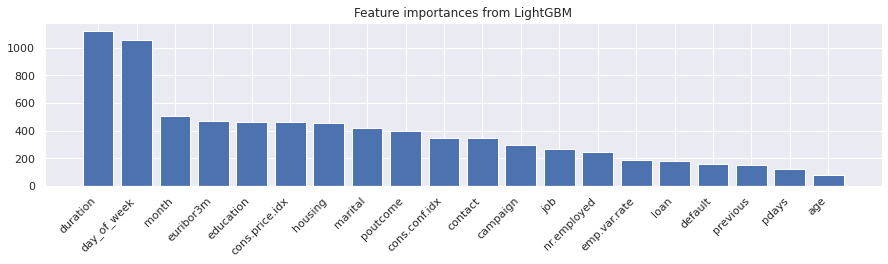

Feature importance XGB


nr.employed   contact  duration  cons.conf.idx     month   default  \
XGB     0.398083  0.146057  0.097231       0.052356  0.051392  0.031958   

     emp.var.rate  cons.price.idx   housing  poutcome   marital  euribor3m  \
XGB      0.028539        0.024142  0.023573  0.022258  0.021722   0.020444   

     previous  day_of_week      loan  education       job  campaign     pdays  \
XGB  0.016201     0.015575  0.011911   0.010619  0.009587   0.00854  0.005766   

          age  
XGB  0.004045

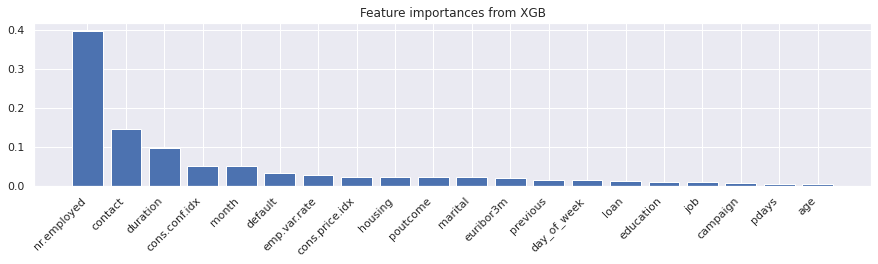

Feature importance CatBoost


day_of_week   duration   housing  education   marital  campaign  \
CatBoost     21.37727  13.075603  11.02839   8.877135  8.005755  7.191581   

          nr.employed   contact     month   default      loan       job  \
CatBoost     5.625316  4.583593  3.180114  3.119465  3.096884  2.719152   

          cons.conf.idx  poutcome  euribor3m  cons.price.idx  previous  \
CatBoost       1.937649  1.613302   1.328666        1.321194  1.167966   

          emp.var.rate     pdays       age  
CatBoost      0.432641  0.266759  0.051564

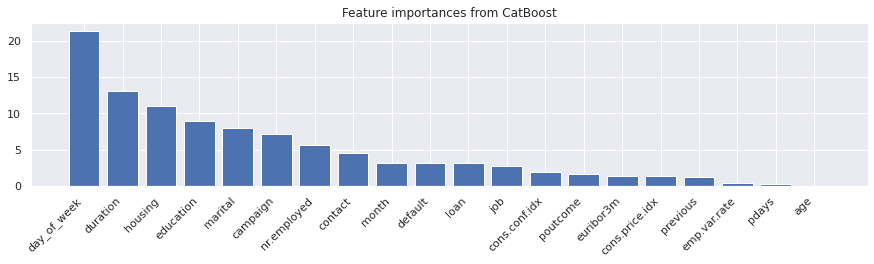

Feature importance Gradient Boosting


duration  nr.employed   contact     month  cons.conf.idx  \
Gradient Boosting   0.41213     0.171708  0.078737  0.065204       0.036217   

                   euribor3m  day_of_week  cons.price.idx  education  \
Gradient Boosting   0.034383     0.034366        0.021735   0.021046   

                    housing       job  poutcome  campaign   marital   default  \
Gradient Boosting  0.017139  0.015334  0.015121  0.012501  0.012415  0.011429   

                        age  emp.var.rate  previous      loan     pdays  
Gradient Boosting  0.010609      0.010344  0.008567  0.007157  0.003857

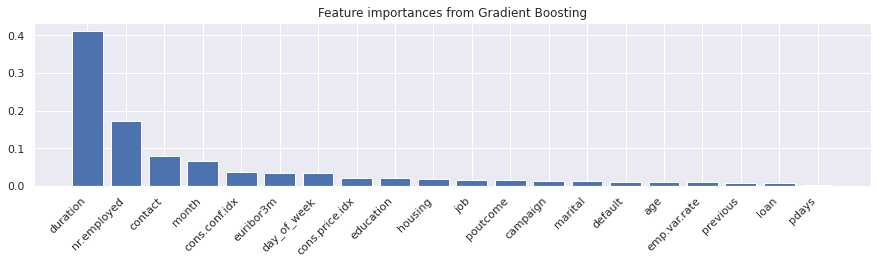

Feature importance Random Forest


duration  nr.employed  euribor3m     month   contact  \
Random Forest  0.338365     0.109758   0.077117  0.069597  0.069137   

               emp.var.rate  cons.conf.idx  cons.price.idx  poutcome  \
Random Forest      0.057269       0.053499         0.02983  0.027492   

                housing  day_of_week   default  previous       job   marital  \
Random Forest  0.025493     0.022056  0.021286  0.019935  0.018394  0.018064   

               education     pdays  campaign     loan       age  
Random Forest   0.014789  0.013278  0.007273  0.00456  0.002808

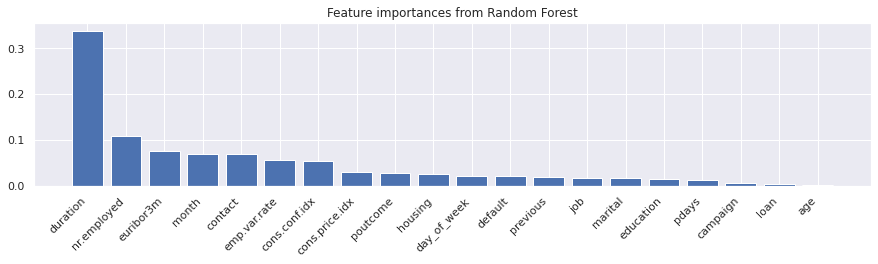

time: 3.38 s (started: 2021-02-09 11:42:10 +00:00)


In [32]:
# only get top 5 models within boosting models
select_models = ['XGB', 'LightGBM', 'CatBoost', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
top_models = models_comp.loc[models_comp["classifier"].isin(select_models)].nlargest(5, "test_f1")["classifier"].values
models_feat_imp = pd.DataFrame()

for key in top_models:
    models_feat_imp = feature_imp_viz(key, dict_models[key]['model'], models_feat_imp, X_train)

In [33]:
# We use a simple ranking mechanism on feature importance of each model - higher number is more important. 
models_feat_imp["Sum"] = models_feat_imp.sum(axis=1)
models_feat_imp.sort_values(by="Sum", ascending=False)

Random Forest  Gradient Boosting  CatBoost   XGB  LightGBM  \
duration                 19.0               19.0      18.0  17.0        19   
month                    16.0               16.0      11.0  15.0        17   
nr.employed              18.0               18.0      13.0  19.0         6   
contact                  15.0               17.0      12.0  18.0         9   
day_of_week               9.0               13.0      19.0   6.0        18   
cons.conf.idx            13.0               15.0       7.0  16.0        10   
housing                  10.0               10.0      17.0  11.0        13   
euribor3m                17.0               14.0       5.0   8.0        16   
cons.price.idx           12.0               12.0       4.0  12.0        14   
education                 4.0               11.0      16.0   4.0        15   
marital                   5.0                6.0      15.0   9.0        12   
poutcome                 11.0                8.0       6.0  10.0        11   
default                   8.0                5.0      10.0  14.0         3   
emp.var.rate             14.0                3.0       2.0  13.0         5   
job                       6.0                9.0       8.0   3.0         7   
campaign                  2.0                7.0      14.0   2.0         8   
previous                  7.0                2.0       3.0   7.0         2   
loan                      1.0                1.0       9.0   5.0         4   
pdays                     3.0                0.0       1.0   1.0         1   
age                       0.0                4.0       0.0   0.0         0   

                 Sum  
duration        92.0  
month           75.0  
nr.employed     74.0  
contact         71.0  
day_of_week     65.0  
cons.conf.idx   61.0  
housing         61.0  
euribor3m       60.0  
cons.price.idx  54.0  
education       50.0  
marital         47.0  
poutcome        46.0  
default         40.0  
emp.var.rate    37.0  
job             33.0  
campaign        33.0  
previous        21.0  
loan            20.0  
pdays            6.0  
age              4.0

time: 24.3 ms (started: 2021-02-09 11:42:14 +00:00)


<a id="References"></a>

# References:
* https://www.kaggle.com/janiobachmann/bank-marketing-campaign-opening-a-term-deposit
* https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
* http://ataspinar.com/2017/05/26/classification-with-scikit-learn/
* https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
* https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 
* https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
* https://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/ 
* https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-ensemble-learning-bagging-and-random-forests

#### I really appreciate your feedbacks, there would be some areas can be fixed and improved.
### If you liked my work please Upvote!
[Back To Table of Contents](#top_section)